Fall Back code

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported i

Holt-Winters - RMSE: 0.0377, R²: 0.9402, KGE: 0.8661
ARIMA - RMSE: 0.0123, R²: 0.9937, KGE: 0.9562


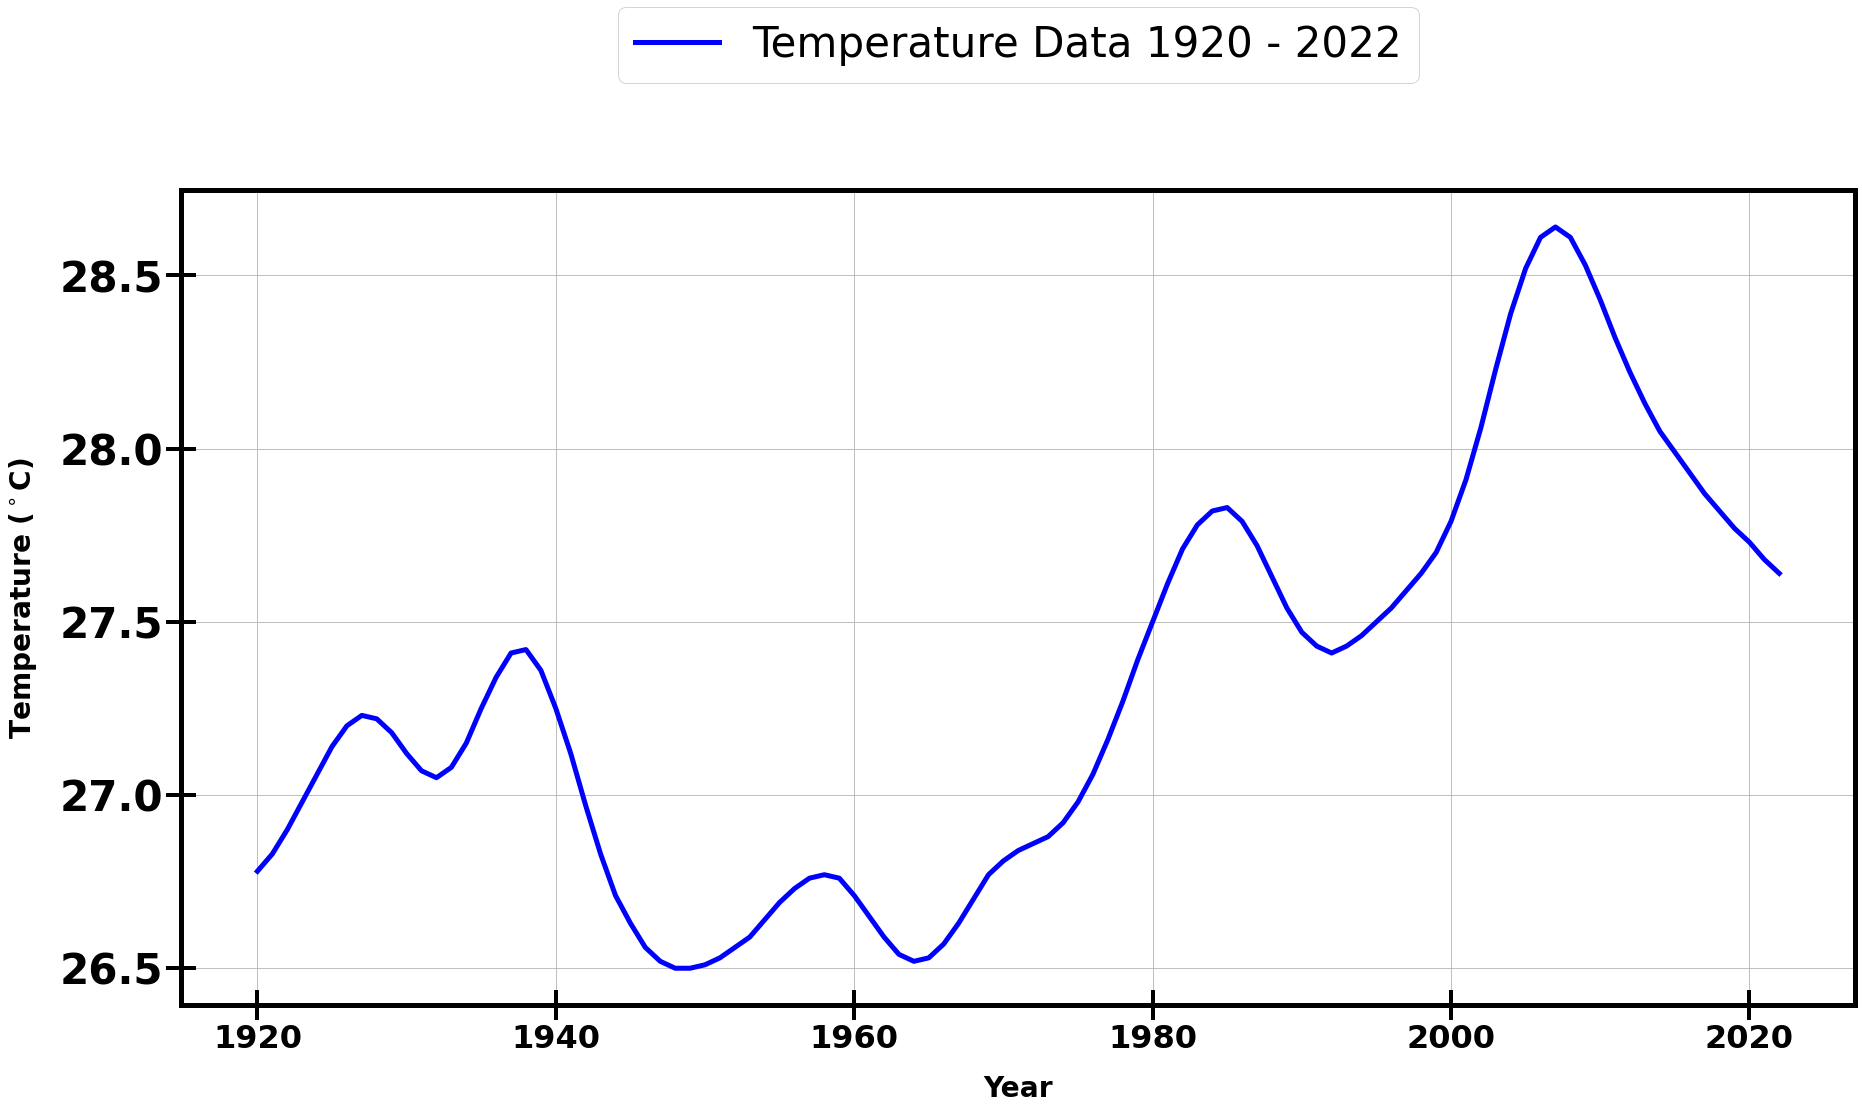

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


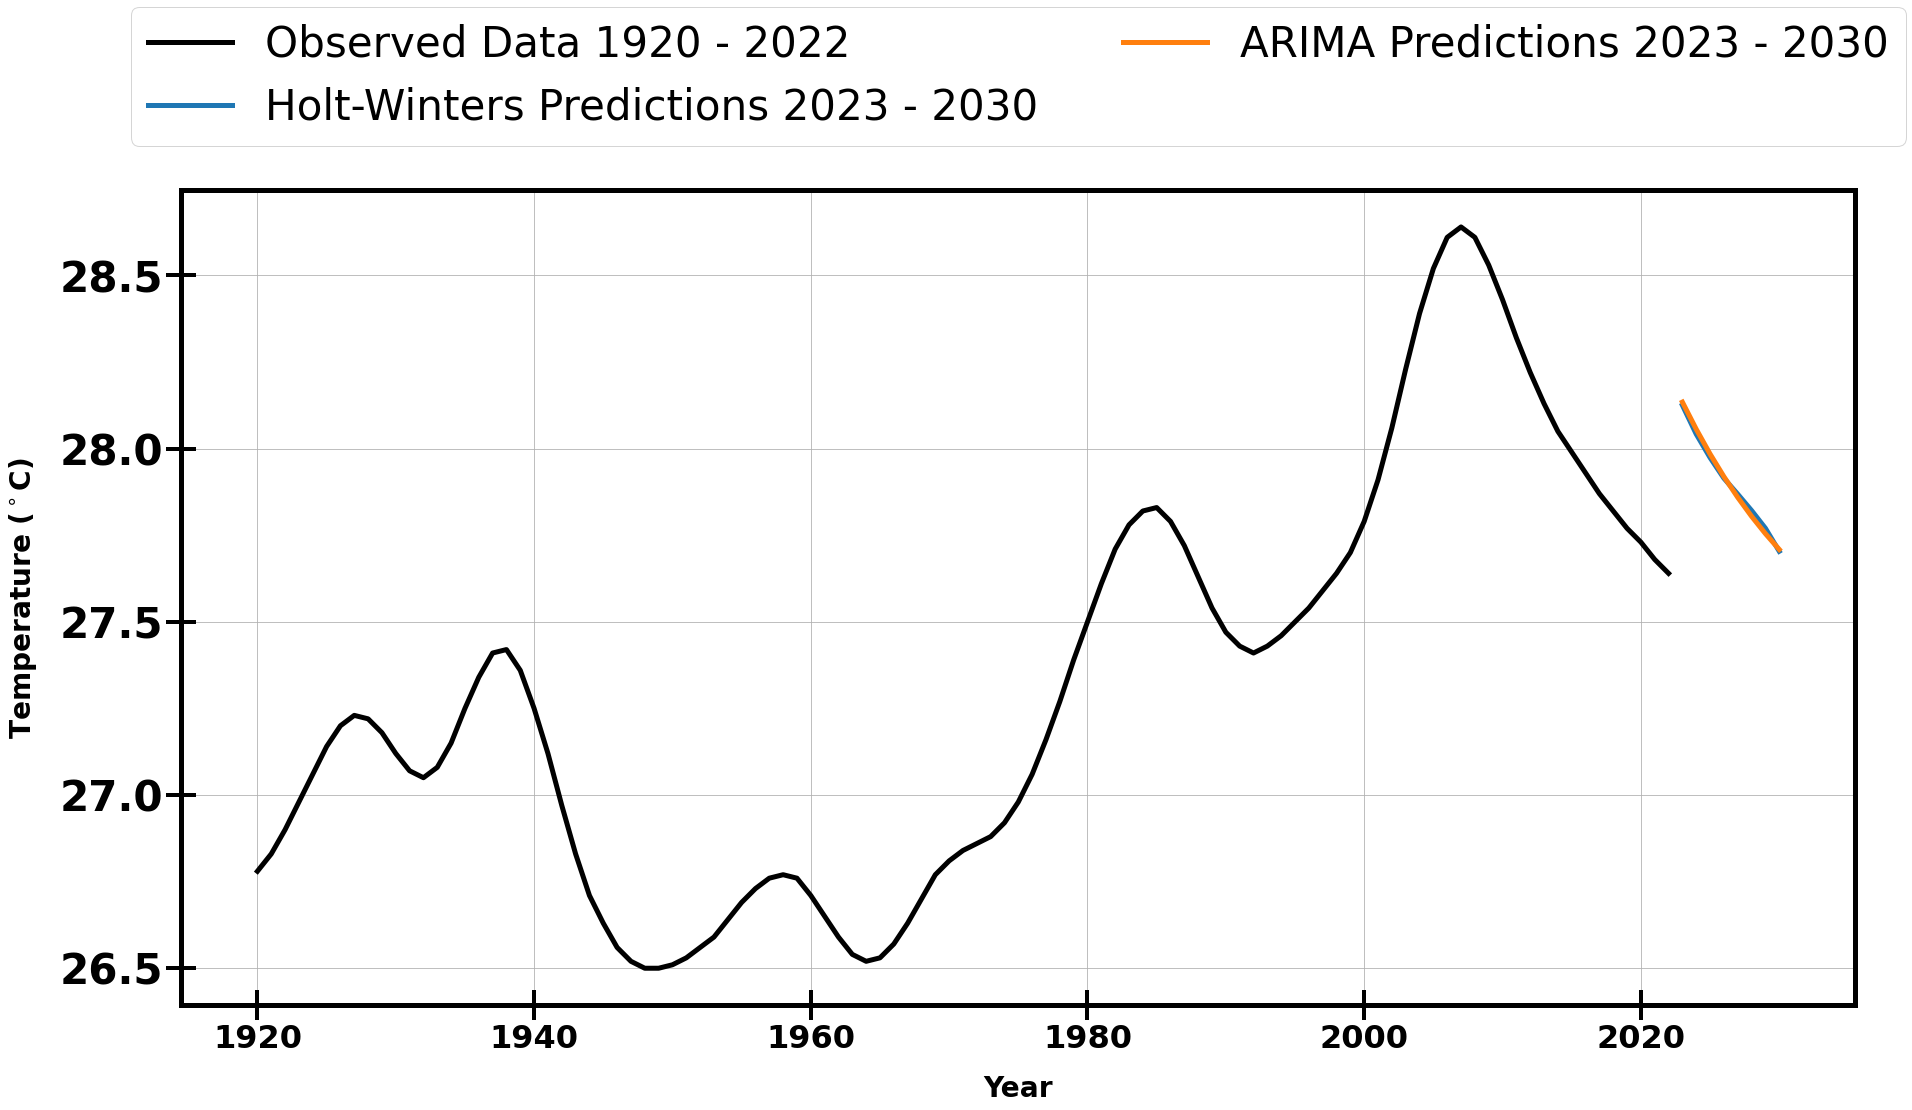

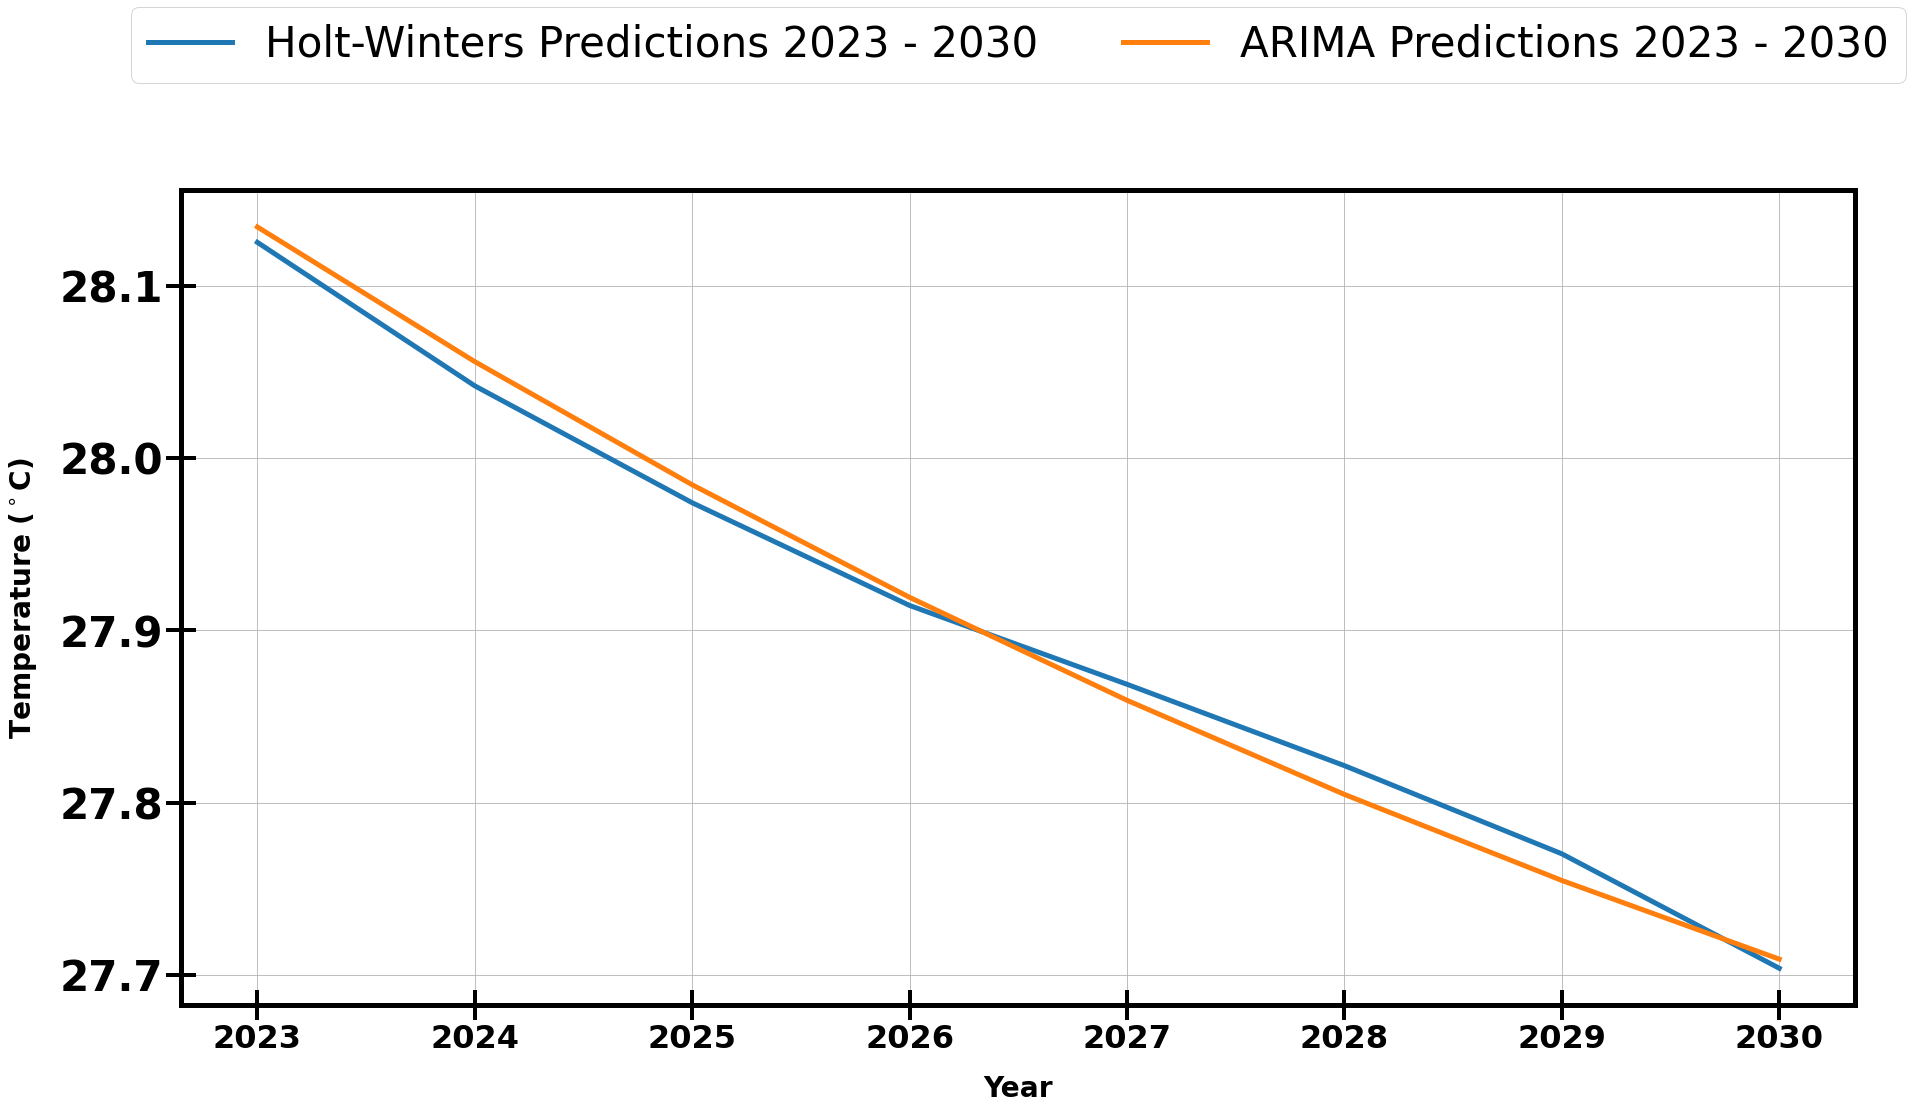

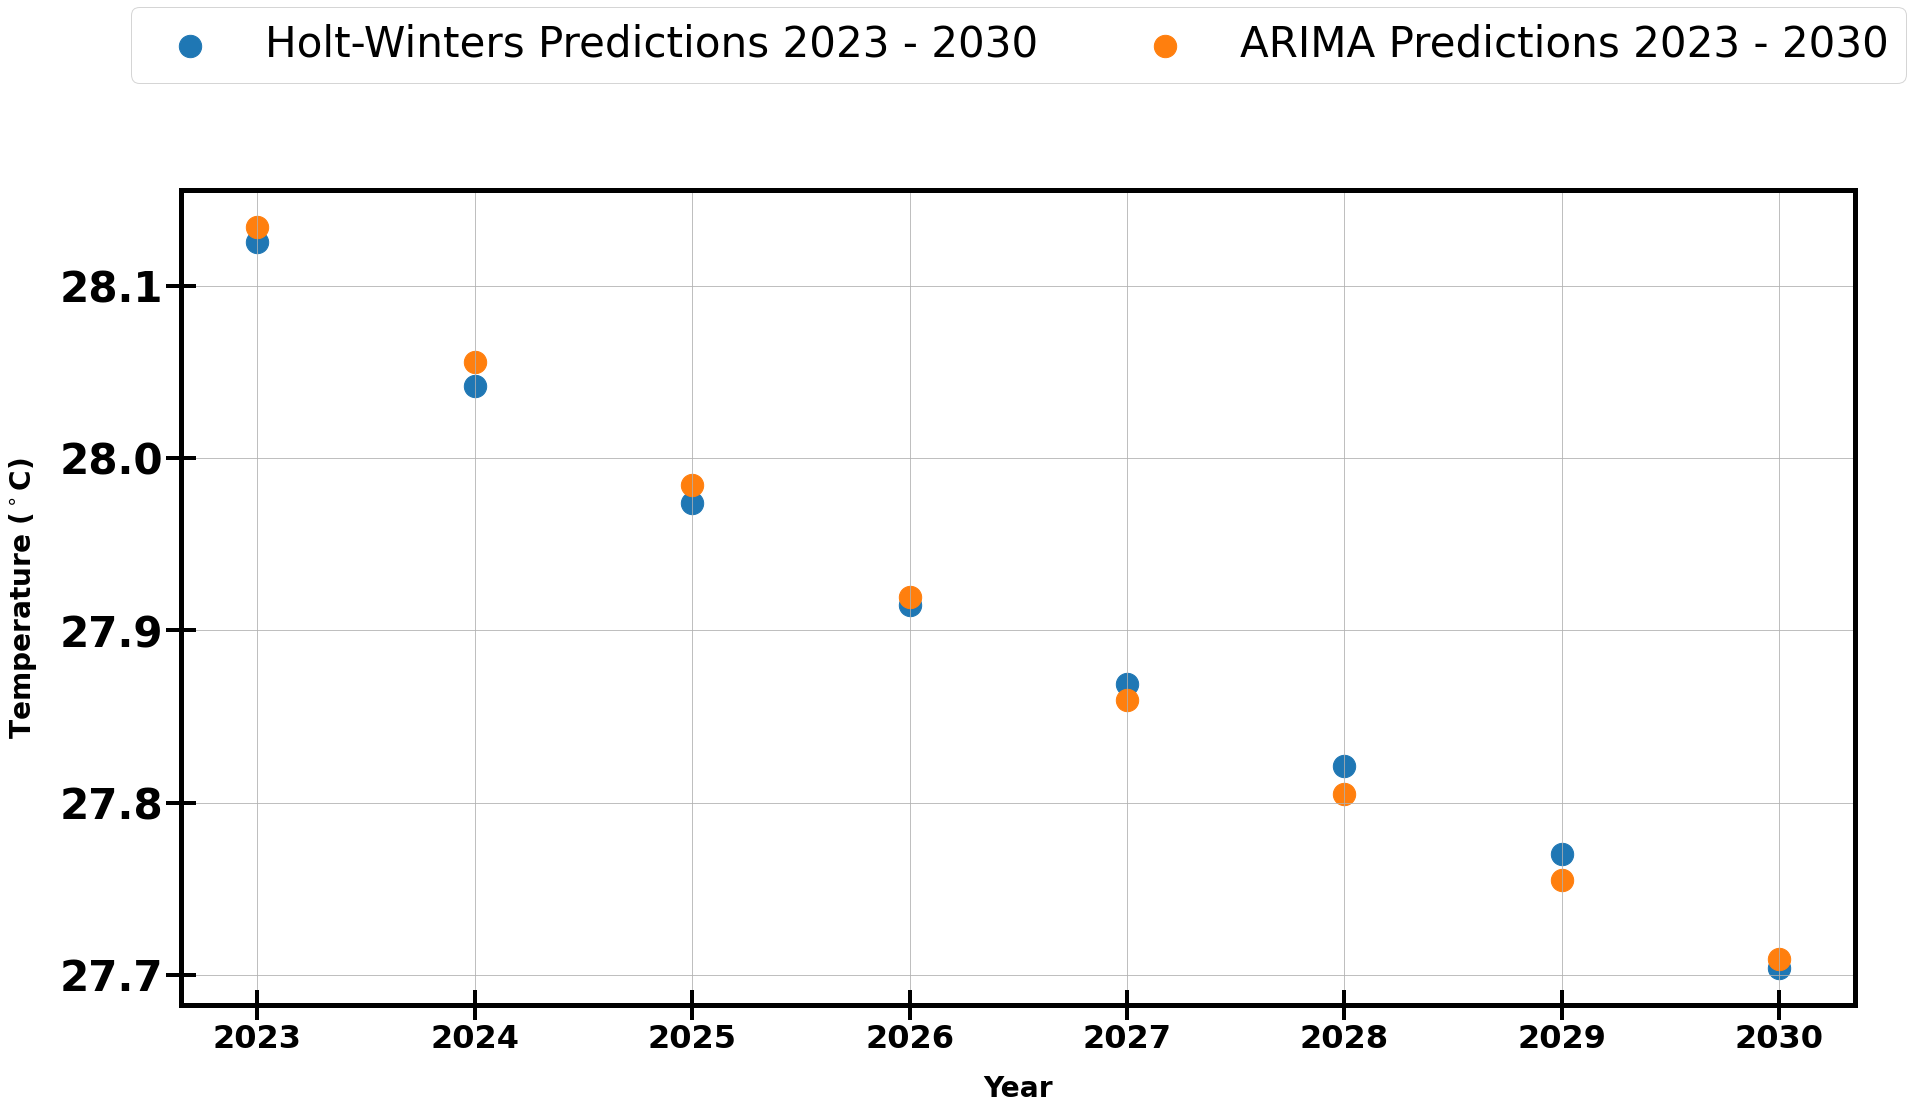

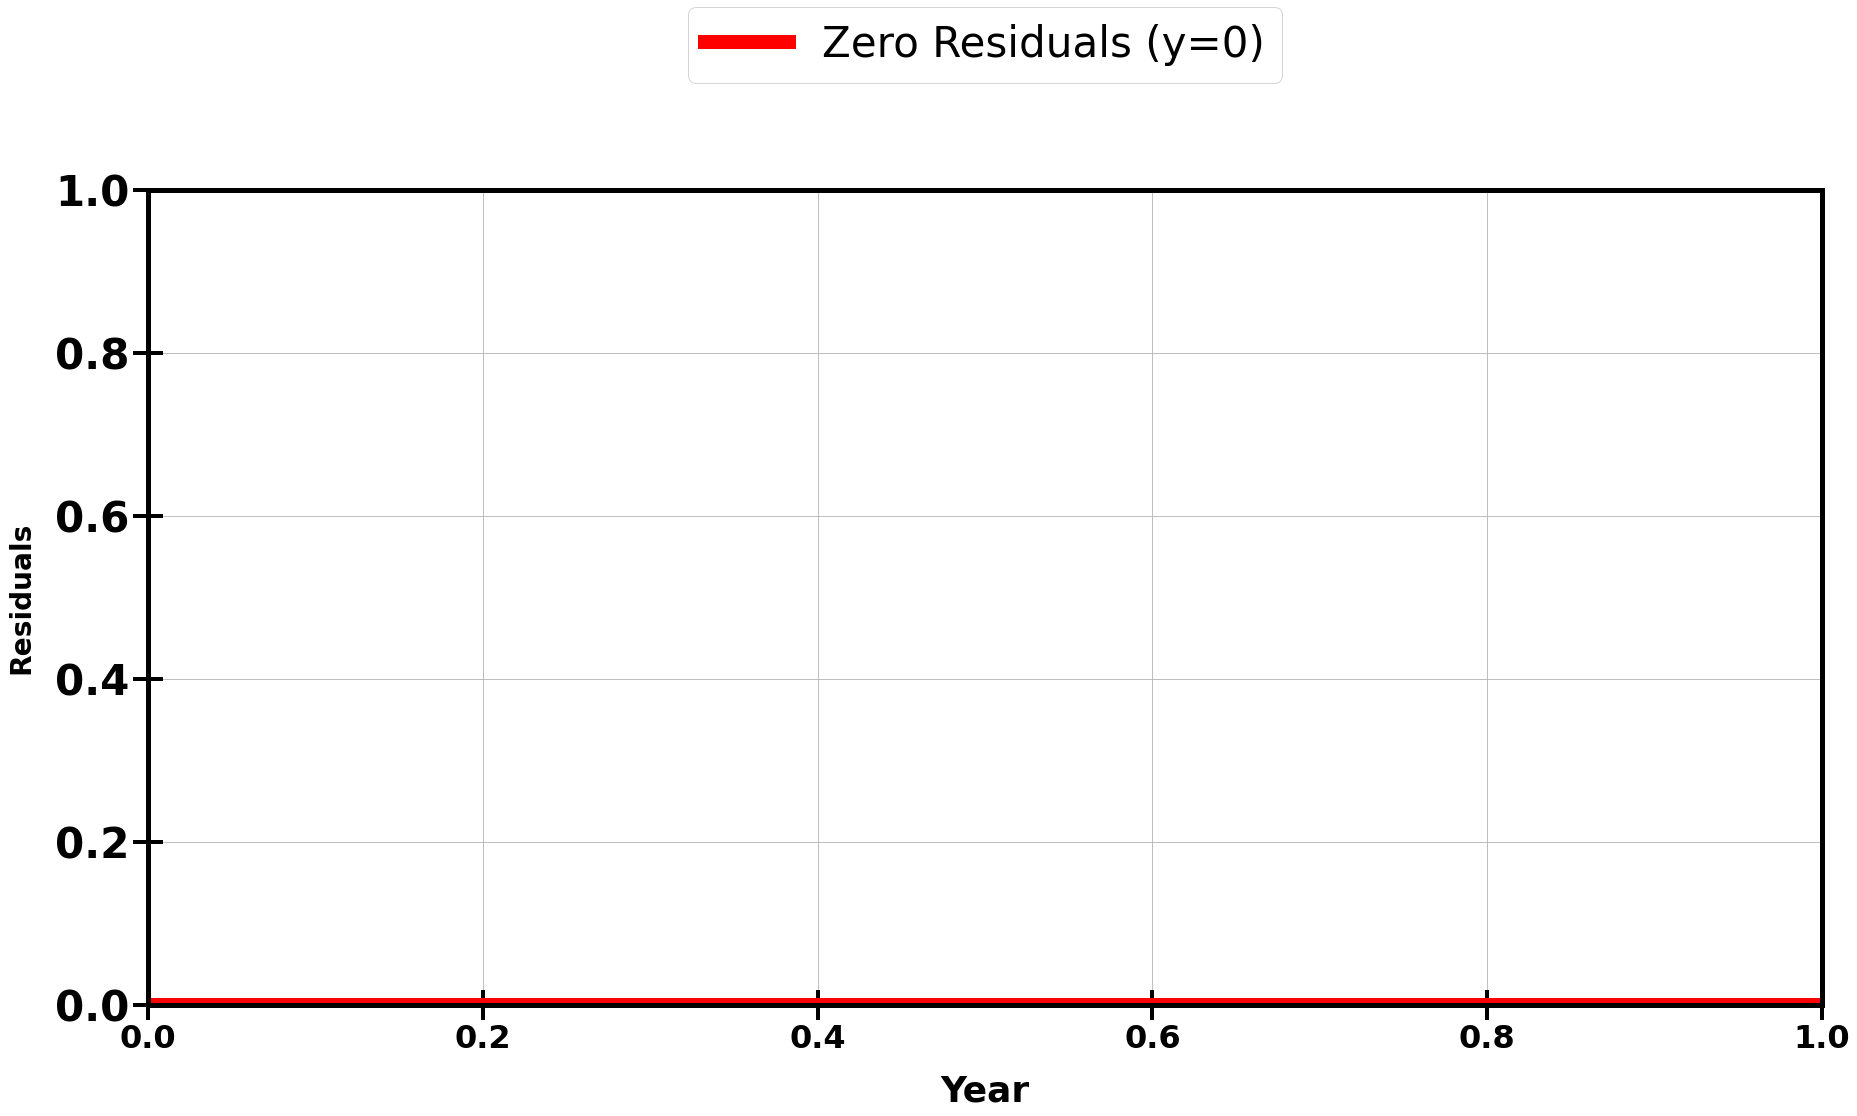

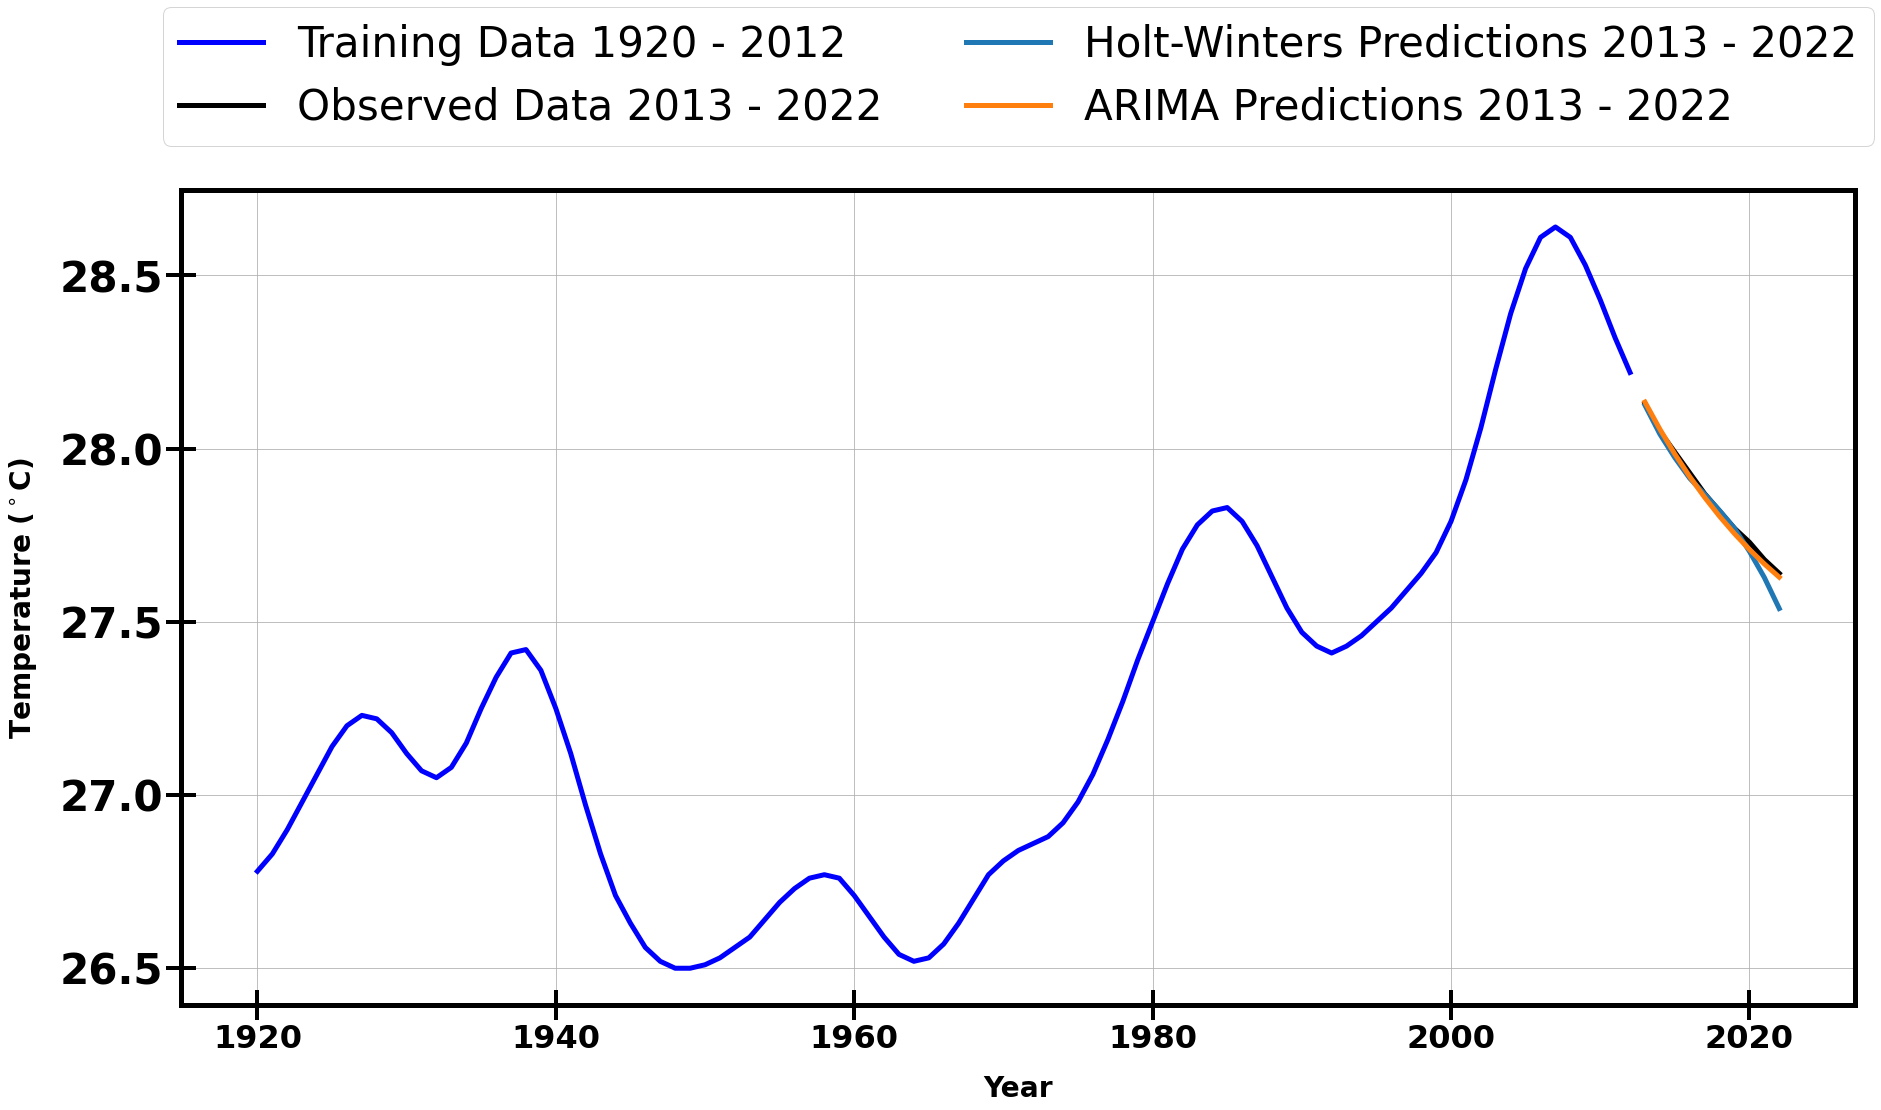

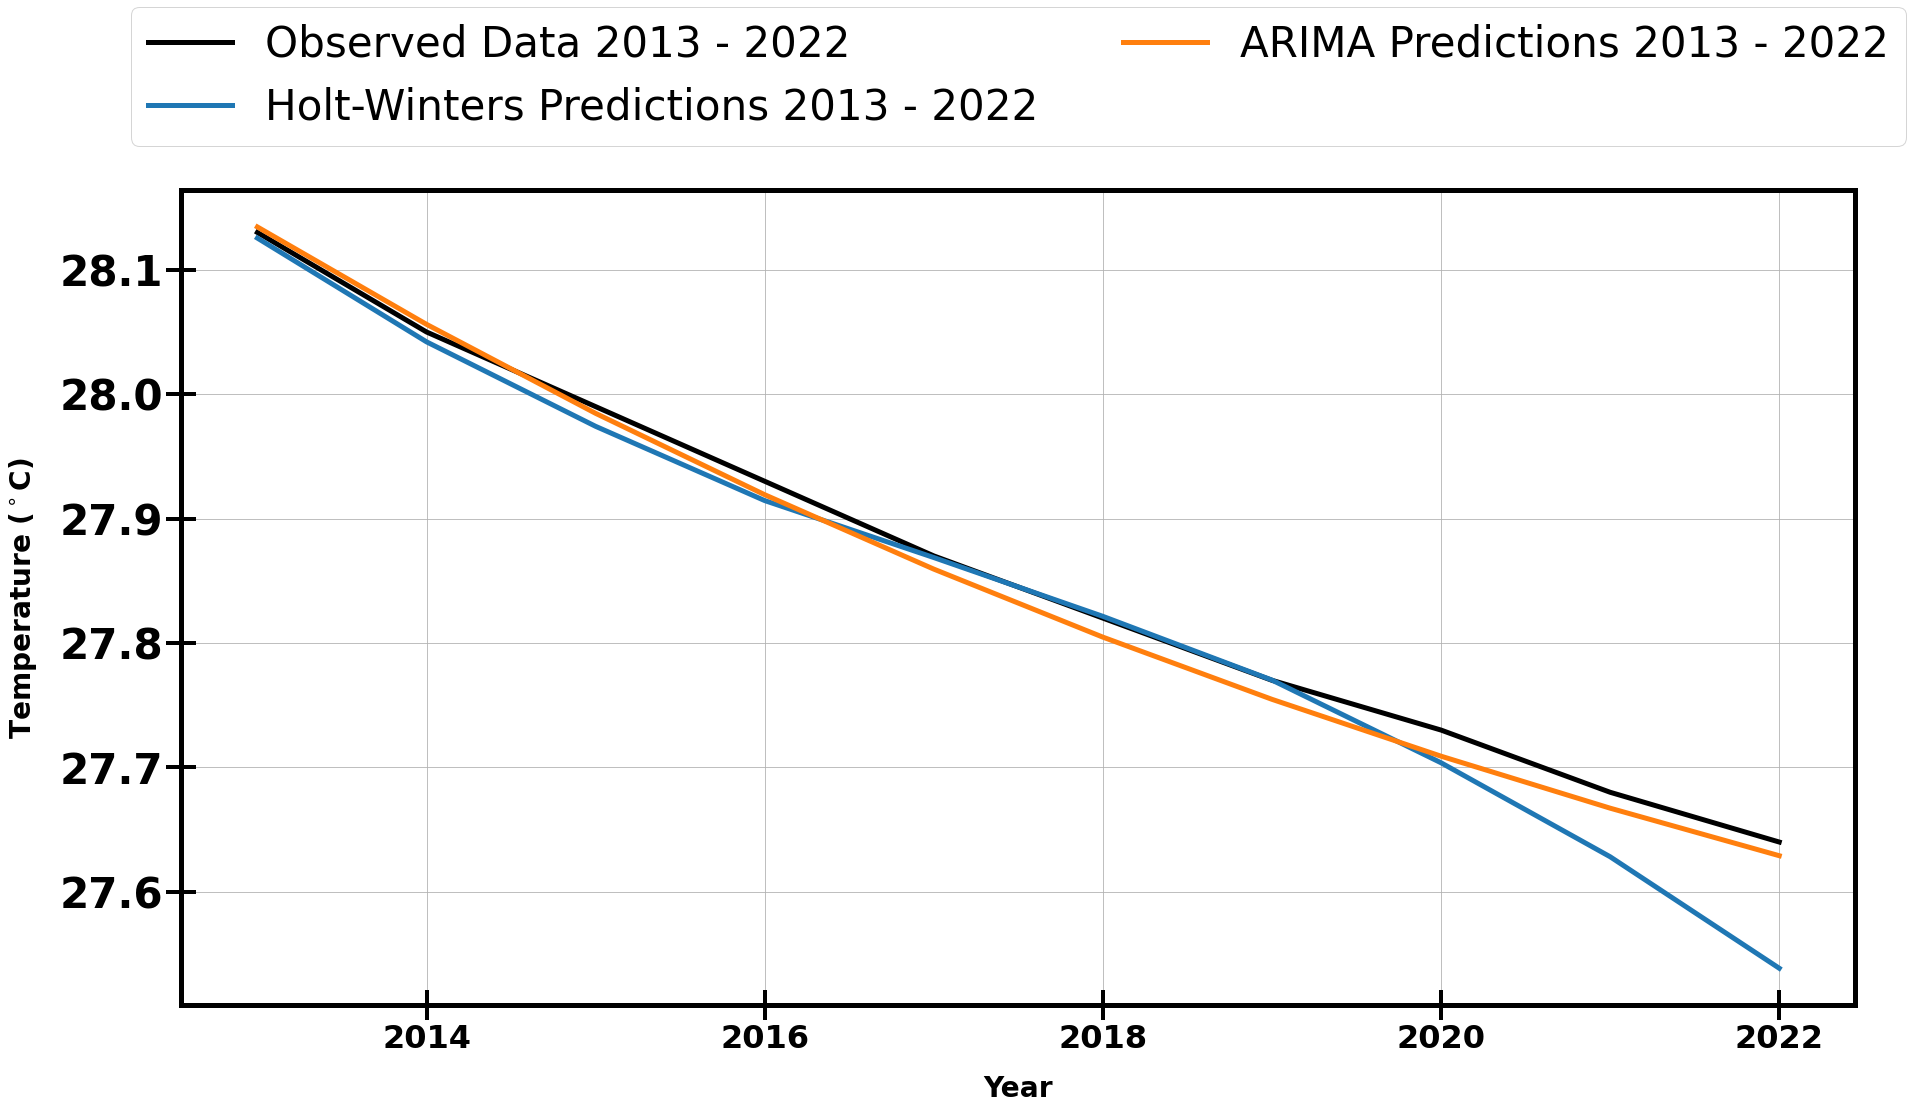

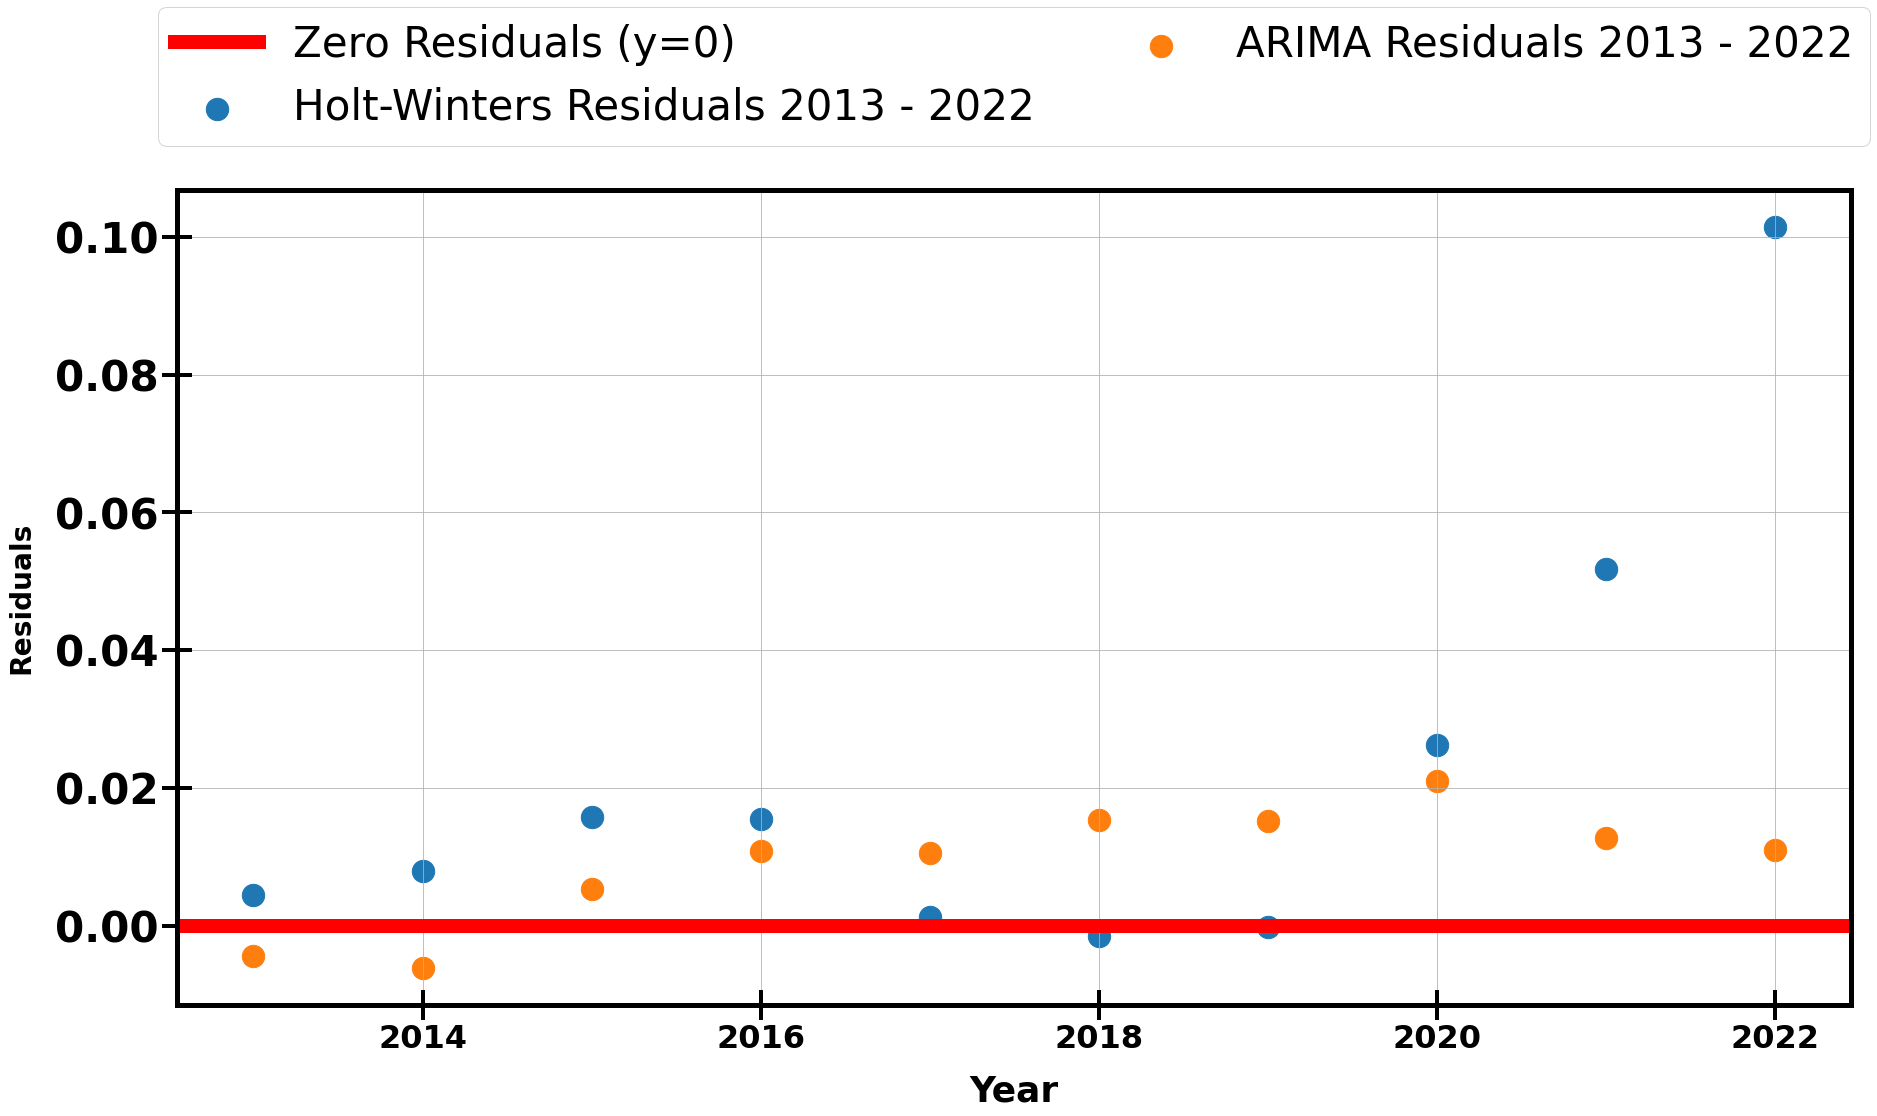

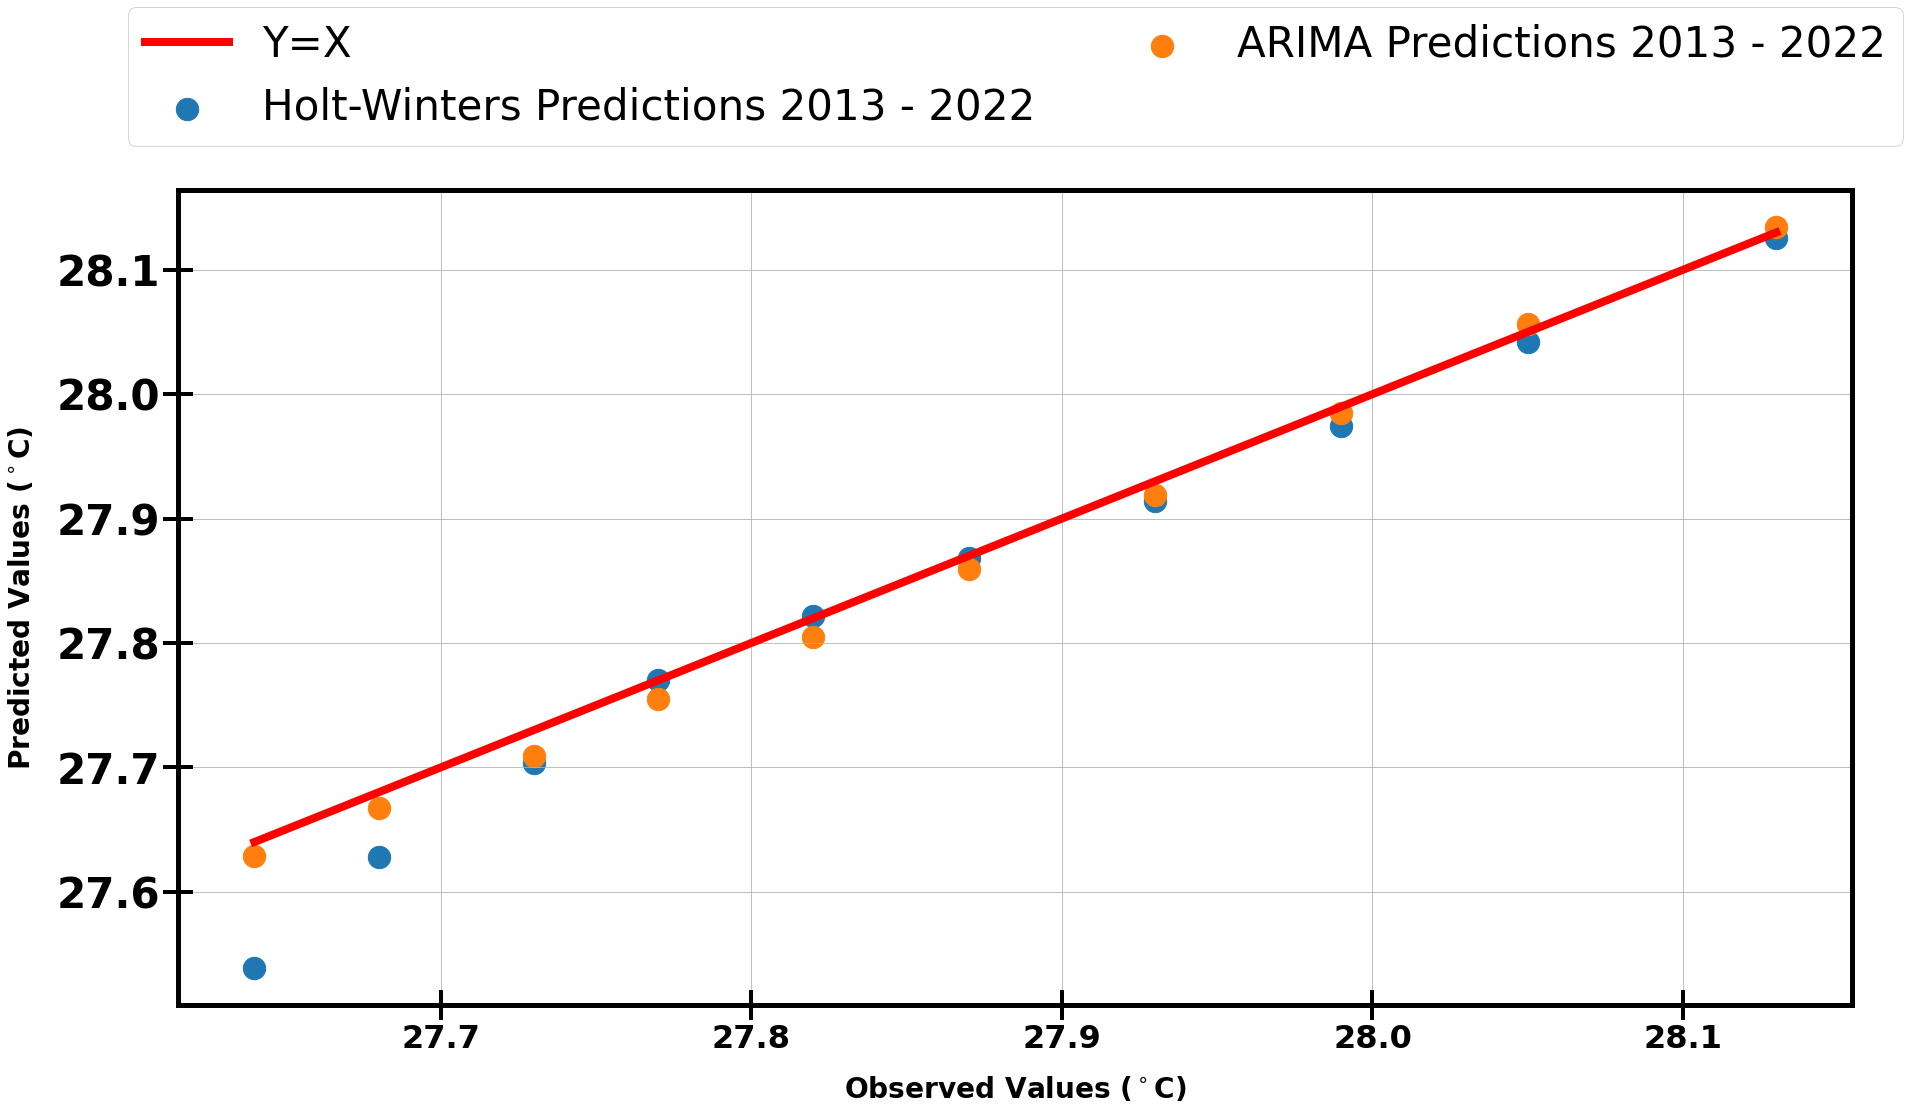

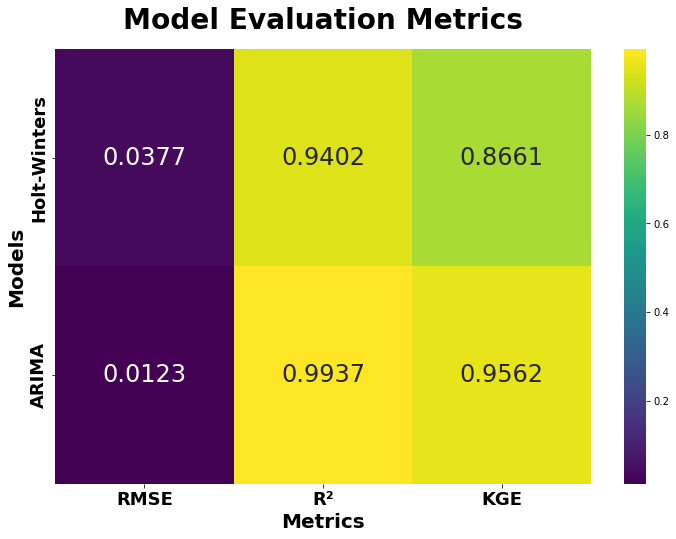

In [13]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA  # For ARIMA
from sklearn.metrics import mean_squared_error, r2_score

# Load Data
data = pd.read_csv('data.csv')  # Ensure filename matches
data.columns = ['Year', 'Annual_Mean', 'Smooth_5yr']  # Ensure proper column names
data = data[['Year', 'Smooth_5yr']]
data = data[data["Year"] >= 1920]
data.set_index('Year', inplace=True)

# Outlier Handling (using rolling and exponential smoothing)
def outlier_removal(df, window=5, alpha=0.1):
    df['Rolling_Mean'] = df['Smooth_5yr'].rolling(window=window).mean()
    df['Exponential_Smoothing'] = df['Smooth_5yr'].ewm(span=window, adjust=False).mean()
    df['Outlier_Enhanced'] = np.where(abs(df['Smooth_5yr'] - df['Exponential_Smoothing']) > 2 * df['Smooth_5yr'].std(), df['Exponential_Smoothing'], df['Smooth_5yr'])
    return df

df = outlier_removal(data)

# Split Data into Training (1990-1999), Validation (2000-2014), and Testing (2015-2025)
train_data = df[df.index <= 2012]
valid_data = df[(df.index > 2012) & (df.index <= 2022)]
test_data = df[df.index > 2022]

# Features and Target
y_train = train_data['Outlier_Enhanced']
y_valid = valid_data['Outlier_Enhanced']
y_test = test_data['Outlier_Enhanced']

# Define Models (adding ARIMA to existing Holt-Winters)
models = {
    "Holt-Winters": ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=12),
    "ARIMA": ARIMA(y_train, order=(1, 1, 1))
}

# Function to Calculate Kling-Gupta Efficiency (KGE)
def kling_gupta_efficiency(observed, predicted):
    r = np.corrcoef(observed, predicted)[0, 1]
    beta = np.mean(predicted) / np.mean(observed)
    alpha = np.std(predicted) / np.std(observed)
    kge = 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    return kge

# Function for Model Training and Evaluation
def train_and_evaluate(model, model_name):
    model_fitted = model.fit()
    predictions = model_fitted.forecast(steps=len(y_valid))

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_valid, predictions))
    r2 = r2_score(y_valid, predictions)
    kge = kling_gupta_efficiency(y_valid.values, predictions)

    return rmse, r2, kge, predictions

# Evaluate All Models
results = {}
predictions_dict = {}
for model_name, model in models.items():
    rmse, r2, kge, predictions = train_and_evaluate(model, model_name)
    results[model_name] = {"RMSE": rmse, "R²": r2, "KGE": kge}
    predictions_dict[model_name] = predictions

# Display Results
for model_name, result in results.items():
    print(f"{model_name} - RMSE: {result['RMSE']:.4f}, R²: {result['R²']:.4f}, KGE: {result['KGE']:.4f}")

# Define the directory to save the plots and results
output_dir = 'output_plots'
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

# Save results to Excel
results_df = pd.DataFrame(results).T
results_df.to_excel(os.path.join(output_dir, 'evaluation_results.xlsx'), index_label='Model')

# New Plot: Time Series Data from 1920 to 2022
plt.figure(figsize=(30, 15))
plt.plot(df.index[df.index <= 2022], df['Outlier_Enhanced'][df.index <= 2022], label='Temperature Data 1920 - 2022', color='blue', linewidth=5)
plt.xlabel('Year', fontsize=28, fontweight='bold', labelpad=20)
plt.ylabel('Temperature ($^\circ$C)', fontsize=28, fontweight='bold', labelpad=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=1, fontsize=42)  # Raised legend

# Increase the thickness of the plot's borders (spines)
for spine in plt.gca().spines.values():
    spine.set_linewidth(5)  # Adjust this value as needed for thicker borders

plt.tick_params(axis='both', which='major', labelsize=32, width=4, length=30, direction='inout')
plt.xticks(fontsize=32, fontweight='bold')
plt.yticks(rotation=360, fontsize=42, fontweight='bold')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'timeseries_1920_2022.png'), dpi=300, bbox_inches='tight')
plt.show()  # Display the plot

# Predictions for 2023 to 2030
future_years = np.arange(2023, 2031)  # Years from 2023 to 2030 (inclusive of 2030)
future_predictions = {}
for model_name, model in models.items():
    model_fitted = model.fit()
    future_predictions[model_name] = model_fitted.forecast(steps=len(future_years))

# New Plot: Predictions from 2023 to 2030 with Observed Data up to 2022
plt.figure(figsize=(30, 15))
plt.plot(df.index[df.index <= 2022], df['Outlier_Enhanced'][df.index <= 2022], label='Observed Data 1920 - 2022', color='black', linewidth=5)
for model_name, predictions in future_predictions.items():
    plt.plot(future_years, predictions, label=f'{model_name} Predictions 2023 - 2030', linewidth=5)
plt.xlabel('Year', fontsize=28, fontweight='bold', labelpad=20)
plt.ylabel('Temperature ($^\circ$C)', fontsize=28, fontweight='bold', labelpad=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fontsize=42)  # Raised legend

# Increase the thickness of the plot's borders (spines)
for spine in plt.gca().spines.values():
    spine.set_linewidth(5)  # Adjust this value as needed for thicker borders

plt.tick_params(axis='both', which='major', labelsize=32, width=4, length=30, direction='inout')
plt.xticks(fontsize=32, fontweight='bold')
plt.yticks(rotation=360, fontsize=42, fontweight='bold')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'predictions_2023_2030.png'), dpi=300, bbox_inches='tight')
plt.show()  # Display the plot

# New Plot: Only Predictions from 2023 to 2030 (No Observed Data)
plt.figure(figsize=(30, 15))
for model_name, predictions in future_predictions.items():
    plt.plot(future_years, predictions, label=f'{model_name} Predictions 2023 - 2030', linewidth=5)
plt.xlabel('Year', fontsize=28, fontweight='bold', labelpad=20)
plt.ylabel('Temperature ($^\circ$C)', fontsize=28, fontweight='bold', labelpad=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fontsize=42)  # Raised legend

# Increase the thickness of the plot's borders (spines)
for spine in plt.gca().spines.values():
    spine.set_linewidth(5)  # Adjust this value as needed for thicker borders

plt.tick_params(axis='both', which='major', labelsize=32, width=4, length=30, direction='inout')
plt.xticks(fontsize=32, fontweight='bold')
plt.yticks(rotation=360, fontsize=42, fontweight='bold')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'predictions_only_2023_2030.png'), dpi=300, bbox_inches='tight')
plt.show()  # Display the plot

# New Plot: Scatter Plot of Predictions 2023 to 2030
plt.figure(figsize=(30, 15))
for model_name, predictions in future_predictions.items():
    plt.scatter(future_years, predictions, label=f'{model_name} Predictions 2023 - 2030', alpha=1, s=500)
plt.xlabel('Year', fontsize=28, fontweight='bold', labelpad=20)
plt.ylabel('Temperature ($^\circ$C)', fontsize=28, fontweight='bold', labelpad=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fontsize=42)  # Raised legend

# Increase the thickness of the plot's borders (spines)
for spine in plt.gca().spines.values():
    spine.set_linewidth(5)  # Adjust this value as needed for thicker borders

plt.tick_params(axis='both', which='major', labelsize=32, width=4, length=30, direction='inout')
plt.xticks(fontsize=32, fontweight='bold')
plt.yticks(rotation=360, fontsize=42, fontweight='bold')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'scatter_predictions_2023_2030.png'), dpi=300, bbox_inches='tight')
plt.show()  # Display the plot

# New Plot: Residuals for Predictions 2023 to 2030
plt.figure(figsize=(30, 15))
for model_name, predictions in future_predictions.items():
    if len(y_test) > 0:  # Check if test data exists for residuals
        residuals = y_test.values[:len(predictions)] - predictions  # Match length with available test data
        plt.scatter(future_years[:len(residuals)], residuals, label=f'{model_name} Residuals 2023 - 2030', alpha=1, s=500)
plt.axhline(y=0, color='r', linestyle='-', label='Zero Residuals (y=0)', linewidth=14)
plt.xlabel('Year', fontsize=36, fontweight='bold', labelpad=20)
plt.ylabel('Residuals', fontsize=28, fontweight='bold', labelpad=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fontsize=42)  # Raised legend

# Increase the thickness of the plot's borders (spines)
for spine in plt.gca().spines.values():
    spine.set_linewidth(5)  # Adjust this value as needed for thicker borders

plt.tick_params(axis='both', which='major', labelsize=32, width=4, length=30, direction='inout')
plt.xticks(fontsize=32, fontweight='bold')
plt.yticks(rotation=360, fontsize=42, fontweight='bold')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'residuals_predictions_2023_2030.png'), dpi=300, bbox_inches='tight')
plt.show()  # Display the plot

# Plotting Training vs Observed vs Prediction for All Models
plt.figure(figsize=(30, 15))
plt.plot(train_data.index, y_train, label='Training Data 1920 - 2012', color='blue', linewidth=5)
plt.plot(valid_data.index, y_valid, label='Observed Data 2013 - 2022', color='black', linewidth=5)
for model_name, predictions in predictions_dict.items():
    plt.plot(valid_data.index, predictions, label=f'{model_name} Predictions 2013 - 2022', linewidth=5)
plt.xlabel('Year', fontsize=28, fontweight='bold', labelpad=20)
plt.ylabel('Temperature ($^\circ$C)', fontsize=28, fontweight='bold', labelpad=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fontsize=42)  # Raised legend

# Increase the thickness of the plot's borders (spines)
for spine in plt.gca().spines.values():
    spine.set_linewidth(5)  # Adjust this value as needed for thicker borders

plt.tick_params(axis='both', which='major', labelsize=32, width=4, length=30, direction='inout')
plt.xticks(fontsize=32, fontweight='bold')
plt.yticks(rotation=360, fontsize=42, fontweight='bold')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'training_vs_observed_vs_prediction.png'), dpi=300, bbox_inches='tight')
plt.show()  # Display the plot

# Plotting Actual vs Predicted for All Models
plt.figure(figsize=(30, 15))
plt.plot(valid_data.index, y_valid, label='Observed Data 2013 - 2022', color='black', linewidth=5)
for model_name, predictions in predictions_dict.items():
    plt.plot(valid_data.index, predictions, label=f'{model_name} Predictions 2013 - 2022', linewidth=5)
plt.xlabel('Year', fontsize=28, fontweight='bold', labelpad=20)
plt.ylabel('Temperature ($^\circ$C)', fontsize=28, fontweight='bold', labelpad=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fontsize=42)  # Raised legend

# Increase the thickness of the plot's borders (spines)
for spine in plt.gca().spines.values():
    spine.set_linewidth(5)  # Adjust this value as needed for thicker borders

plt.tick_params(axis='both', which='major', labelsize=32, width=4, length=30, direction='inout')
plt.xticks(fontsize=32, fontweight='bold')
plt.yticks(rotation=360, fontsize=42, fontweight='bold')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'observed_vs_predictions.png'), dpi=300, bbox_inches='tight')
plt.show()  # Display the plot

# Plot Residuals (Actual - Predicted)
plt.figure(figsize=(30, 15))  # Adjust the size (14, 8) to your preferred dimensions
for model_name, predictions in predictions_dict.items():
    residuals = y_valid.values - predictions  # Ensure the same length for residuals
    plt.scatter(valid_data.index, residuals, label=f'{model_name} Residuals 2013 - 2022', alpha=1, s=500)
plt.axhline(y=0, color='r', linestyle='-', label='Zero Residuals (y=0)', linewidth=14)
plt.xlabel('Year', fontsize=36, fontweight='bold', labelpad=20)
plt.ylabel('Residuals', fontsize=28, fontweight='bold', labelpad=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fontsize=42)  # Raised legend

# Increase the thickness of the plot's borders (spines)
for spine in plt.gca().spines.values():
    spine.set_linewidth(5)  # Adjust this value as needed for thicker borders

plt.tick_params(axis='both', which='major', labelsize=32, width=4, length=30, direction='inout')
plt.xticks(fontsize=32, fontweight='bold')
plt.yticks(rotation=360, fontsize=42, fontweight='bold')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'residuals_vs_observed.png'), dpi=300, bbox_inches='tight')
plt.show()  # Display the plot

# Scatter plot of predictions against observed values
plt.figure(figsize=(30, 15))
for model_name, predictions in predictions_dict.items():
    plt.scatter(y_valid, predictions, label=f'{model_name} Predictions 2013 - 2022', alpha=1, s=500)
plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)], color='red', linestyle='-', label='Y=X', linewidth=8)
plt.xlabel('Observed Values ($^\circ$C)', fontsize=28, fontweight='bold', labelpad=20)
plt.ylabel('Predicted Values ($^\circ$C)', fontsize=28, fontweight='bold', labelpad=20)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fontsize=42)  # Raised legend

# Increase the thickness of the plot's borders (spines)
for spine in plt.gca().spines.values():
    spine.set_linewidth(5)  # Adjust this value as needed for thicker borders

plt.tick_params(axis='both', which='major', labelsize=32, width=4, length=30, direction='inout')
plt.xticks(fontsize=32, fontweight='bold')
plt.yticks(rotation=360, fontsize=42, fontweight='bold')
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'scatter_predictions_vs_observed.png'), dpi=300, bbox_inches='tight')
plt.show()  # Display the plot

# Heatmap of Evaluation Metrics
metrics = pd.DataFrame(results).T
plt.figure(figsize=(12, 8))  # Slightly increased figure size for better readability
sns.heatmap(metrics[['RMSE', 'R²', 'KGE']], annot=True, cmap='viridis', fmt='.4f', cbar=True, 
            annot_kws={"size": 24},  # Increased font size for annotations
            xticklabels=['RMSE', 'R²', 'KGE'], yticklabels=metrics.index)
plt.title('Model Evaluation Metrics', fontsize=28, fontweight='bold', pad=20)
plt.xlabel('Metrics', fontsize=20, fontweight='bold')
plt.ylabel('Models', fontsize=20, fontweight='bold')
plt.xticks(fontsize=18, fontweight='bold')
plt.yticks(fontsize=18, fontweight='bold')
plt.savefig(os.path.join(output_dir, 'evaluation_metrics_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()

Updated code

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported i

Holt-Winters - RMSE: 0.0377, R²: 0.9402, KGE: 0.8661
ARIMA - RMSE: 0.0123, R²: 0.9937, KGE: 0.9562


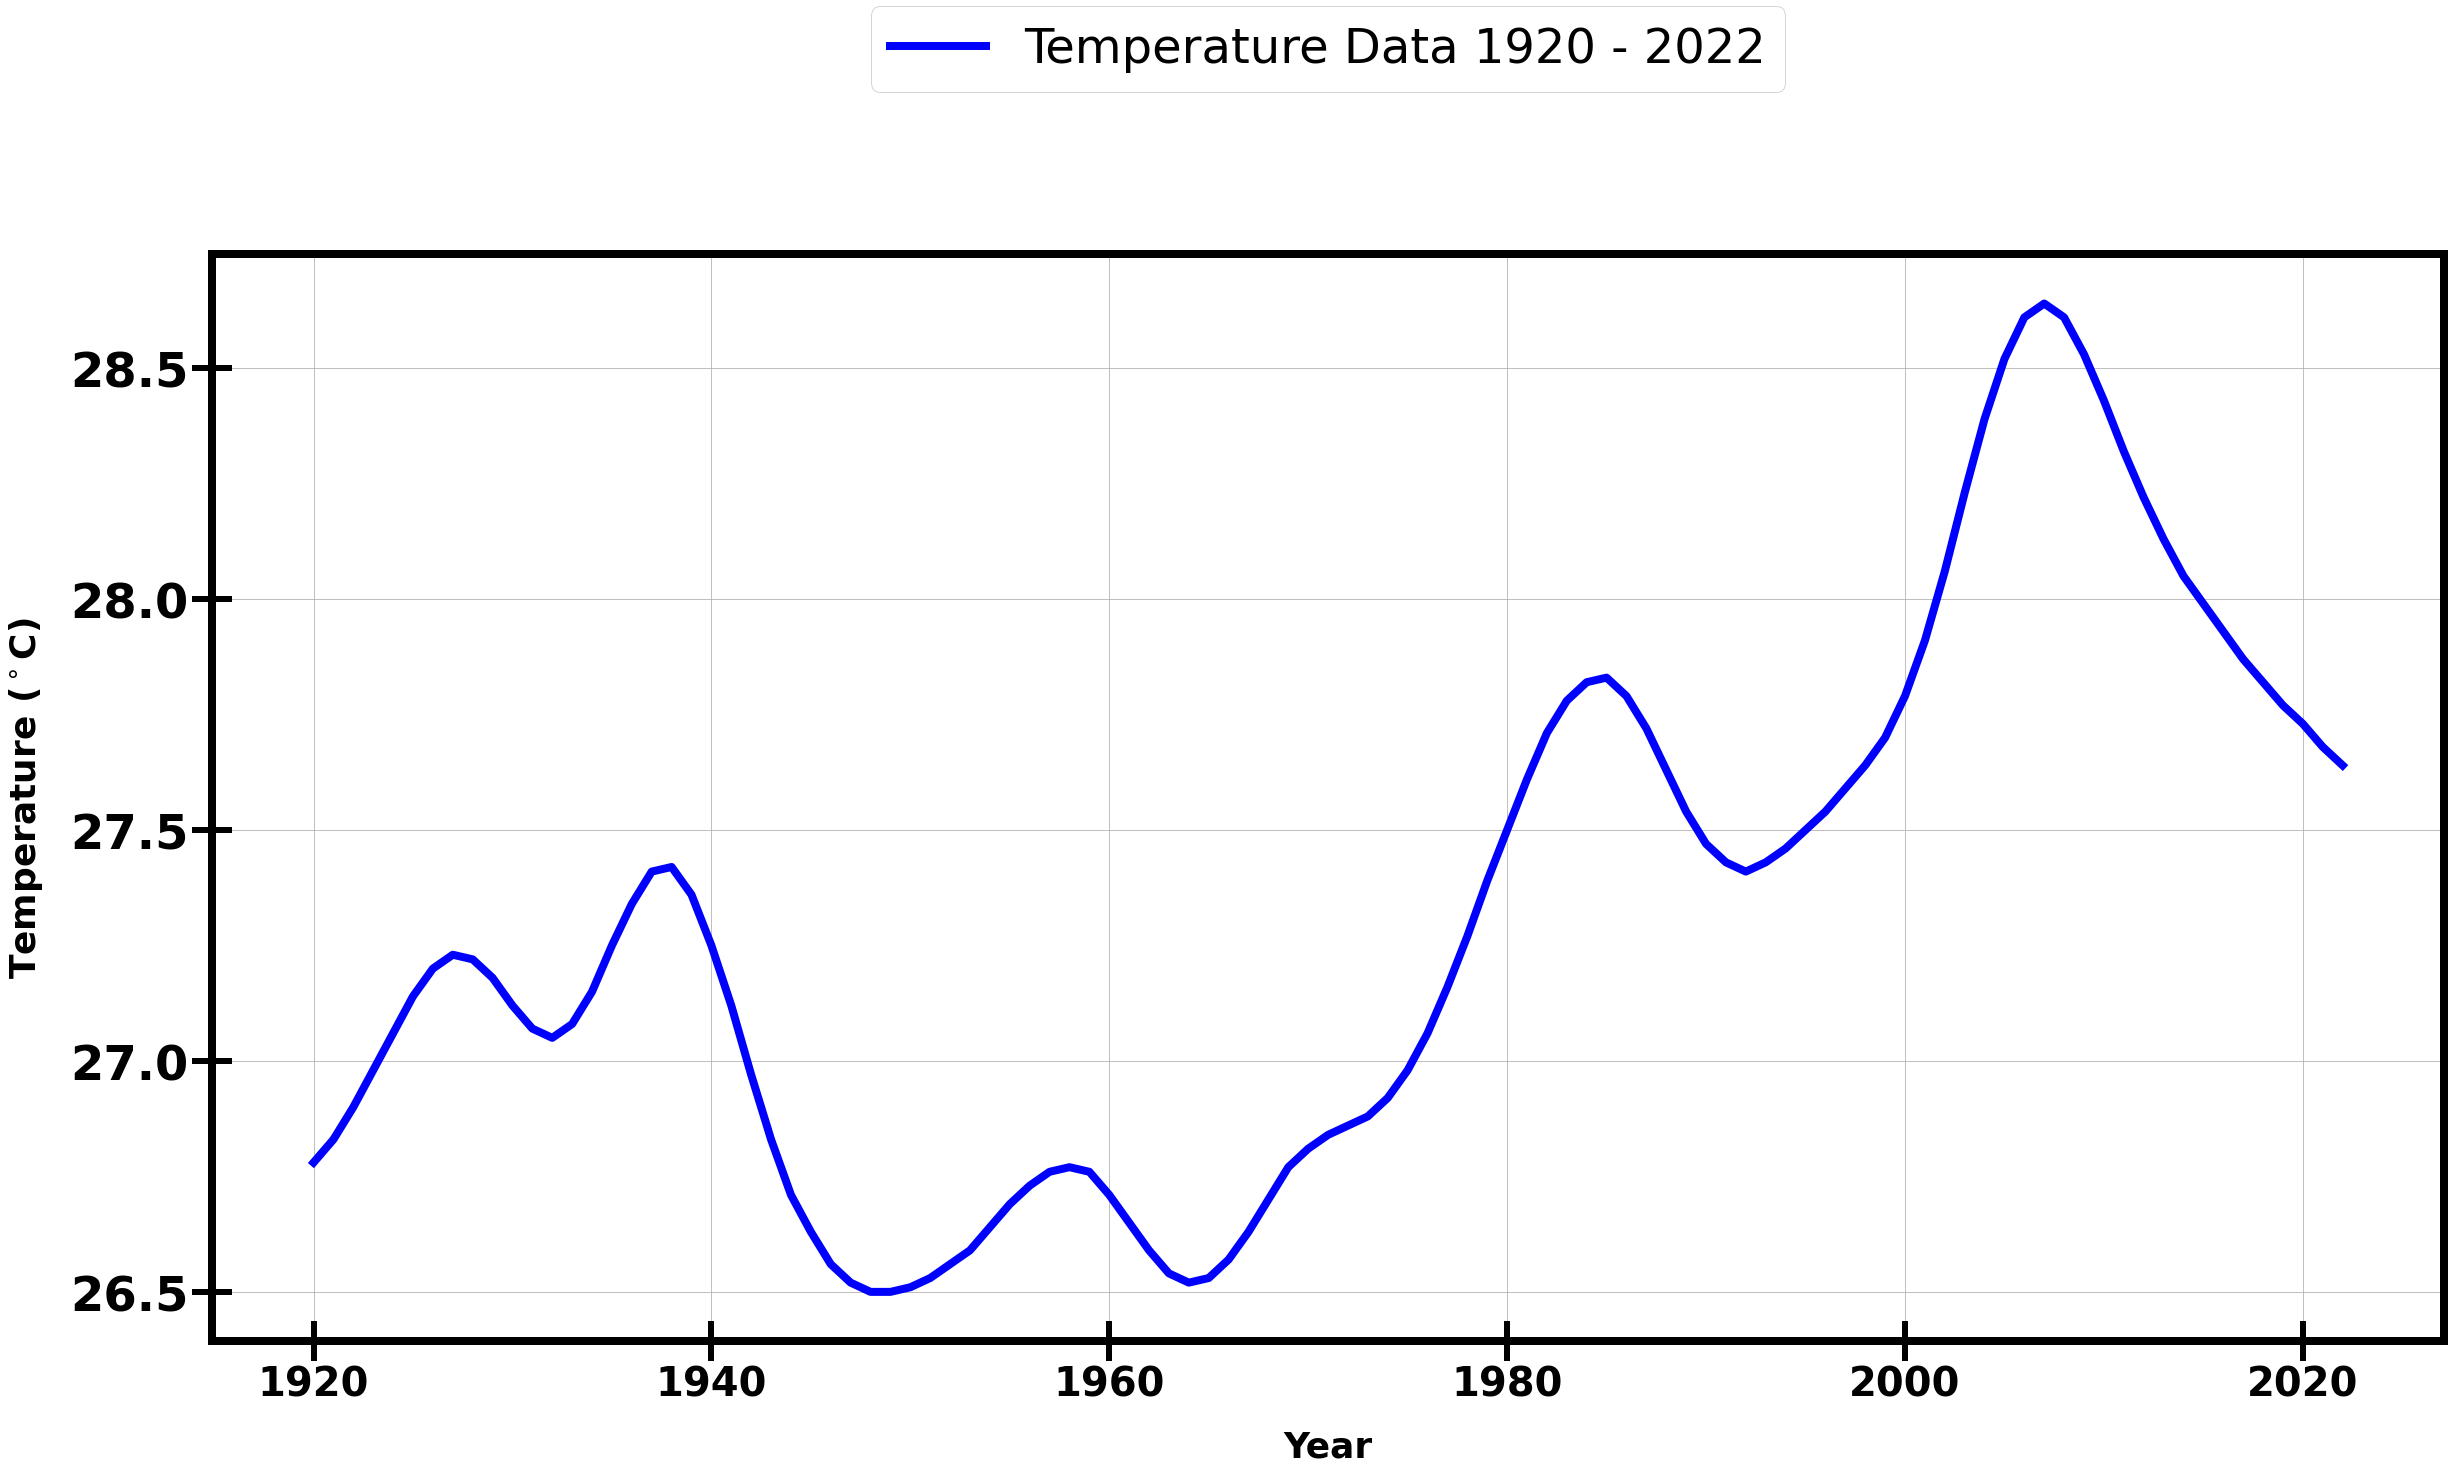

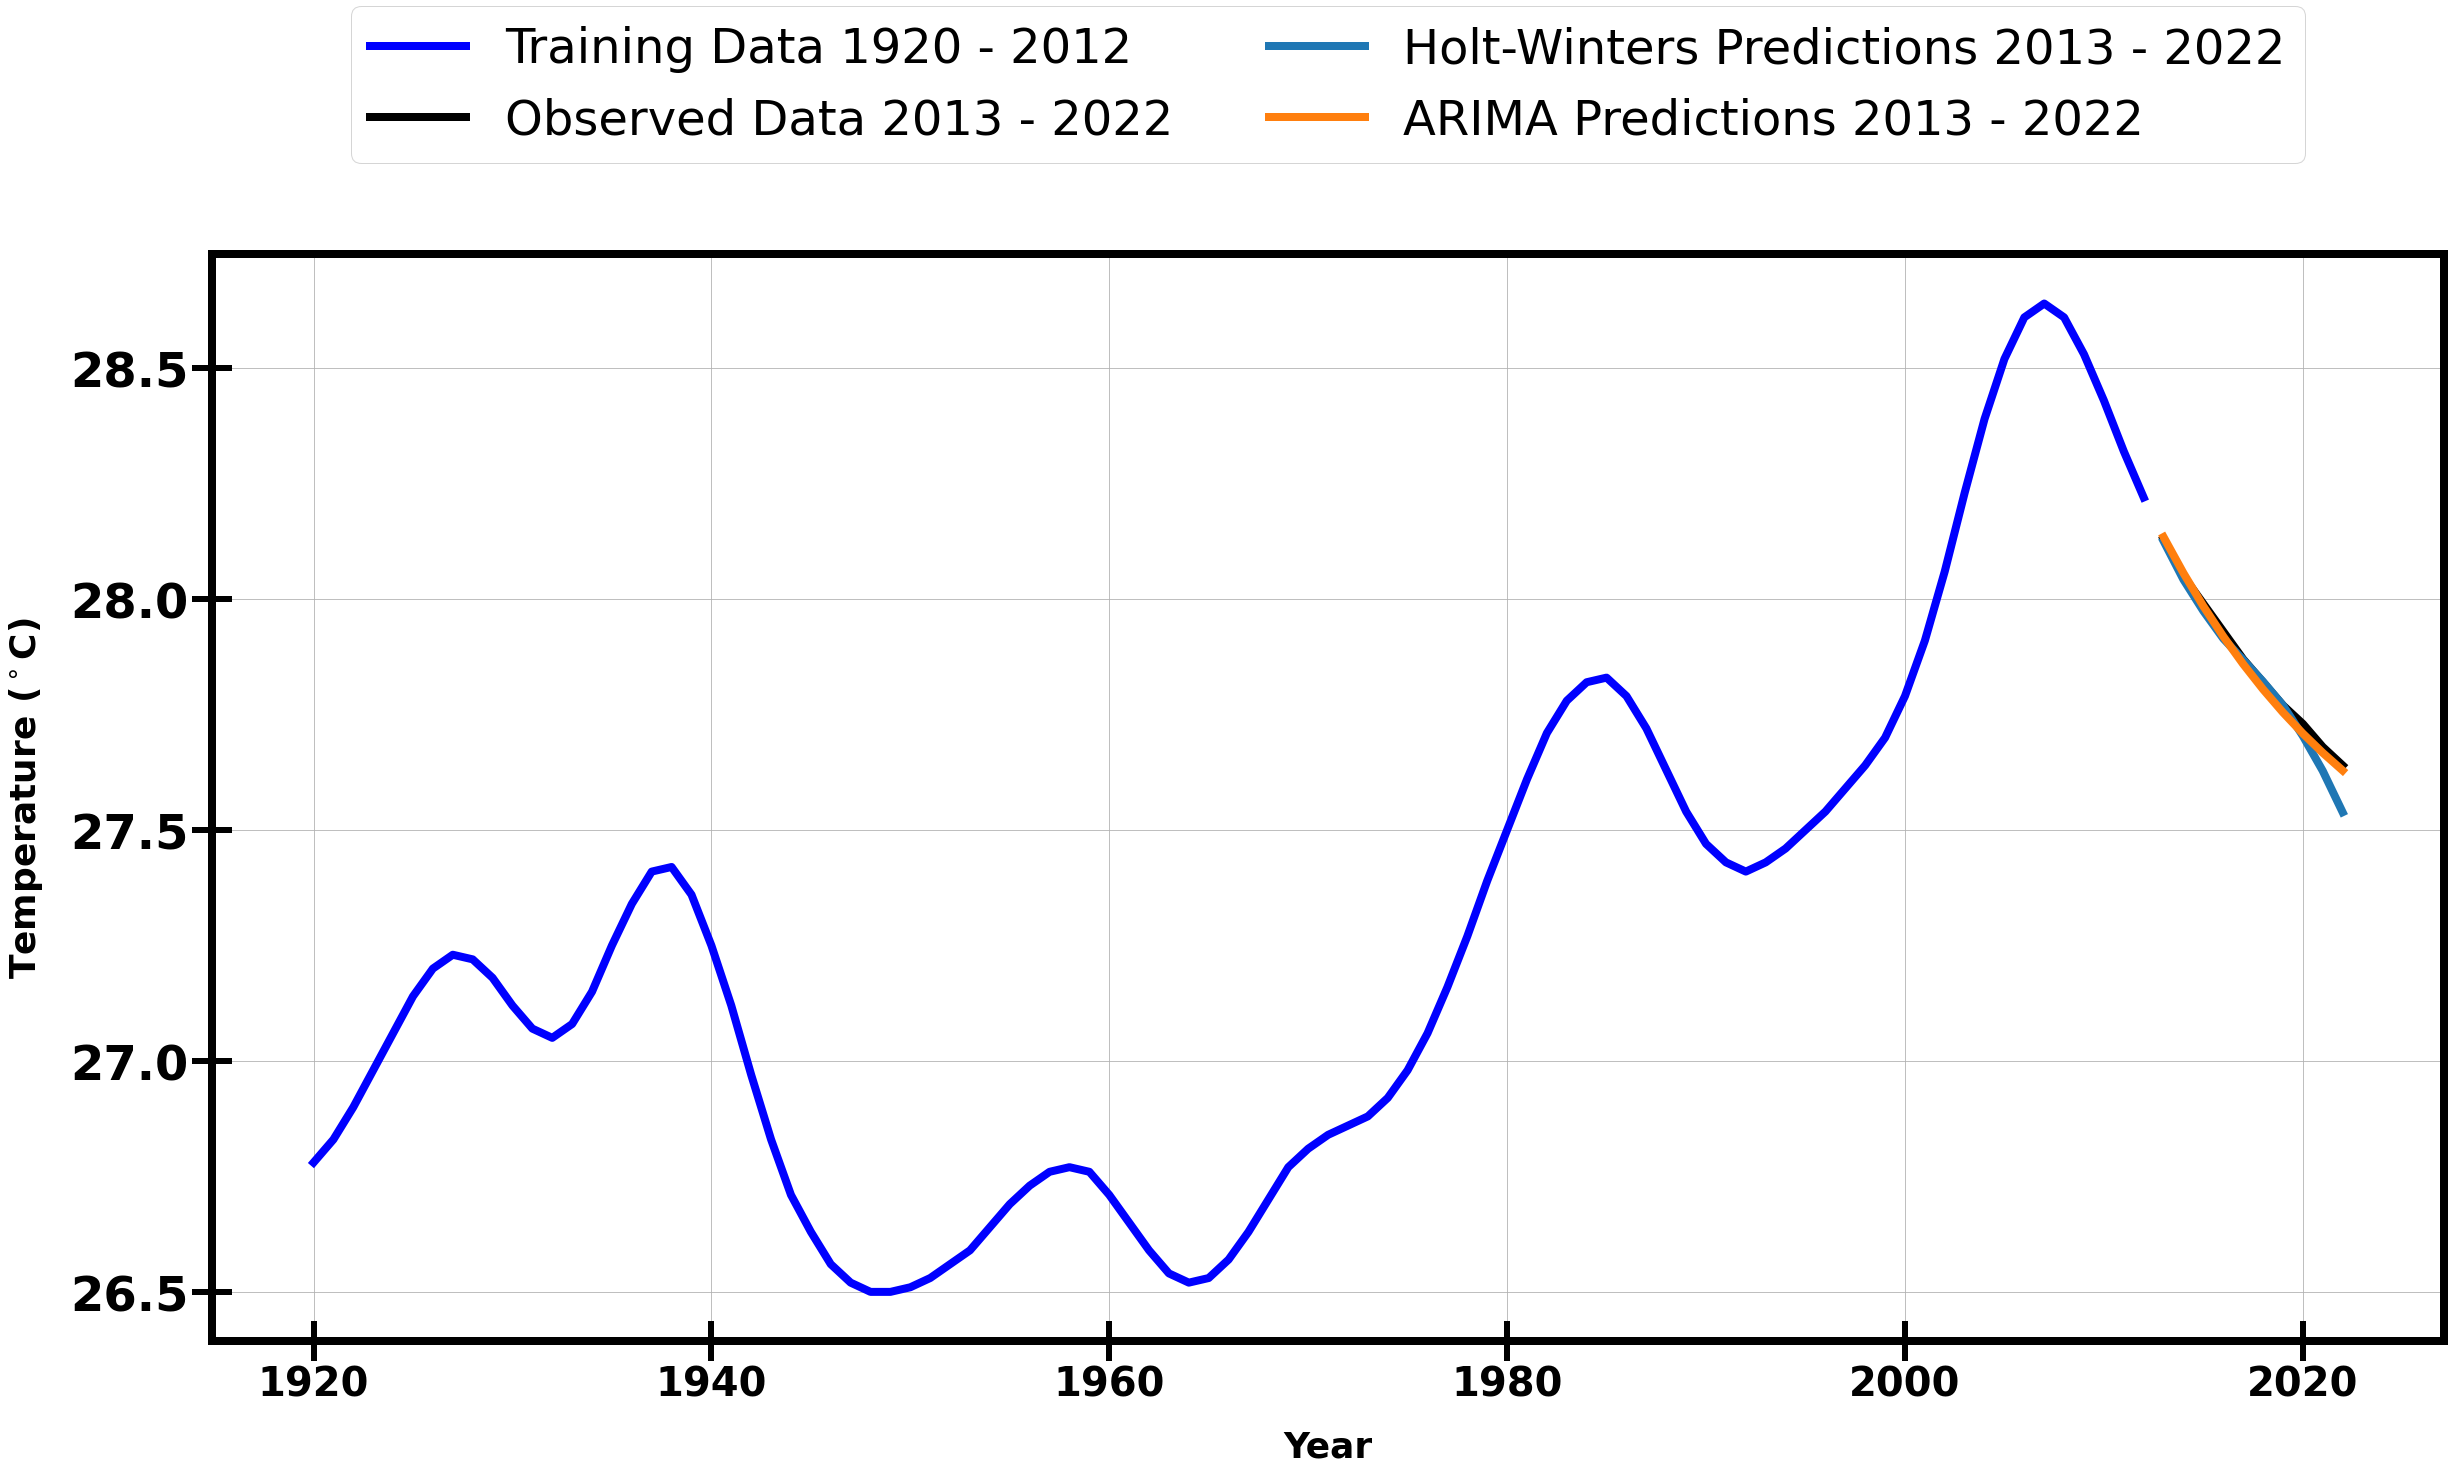

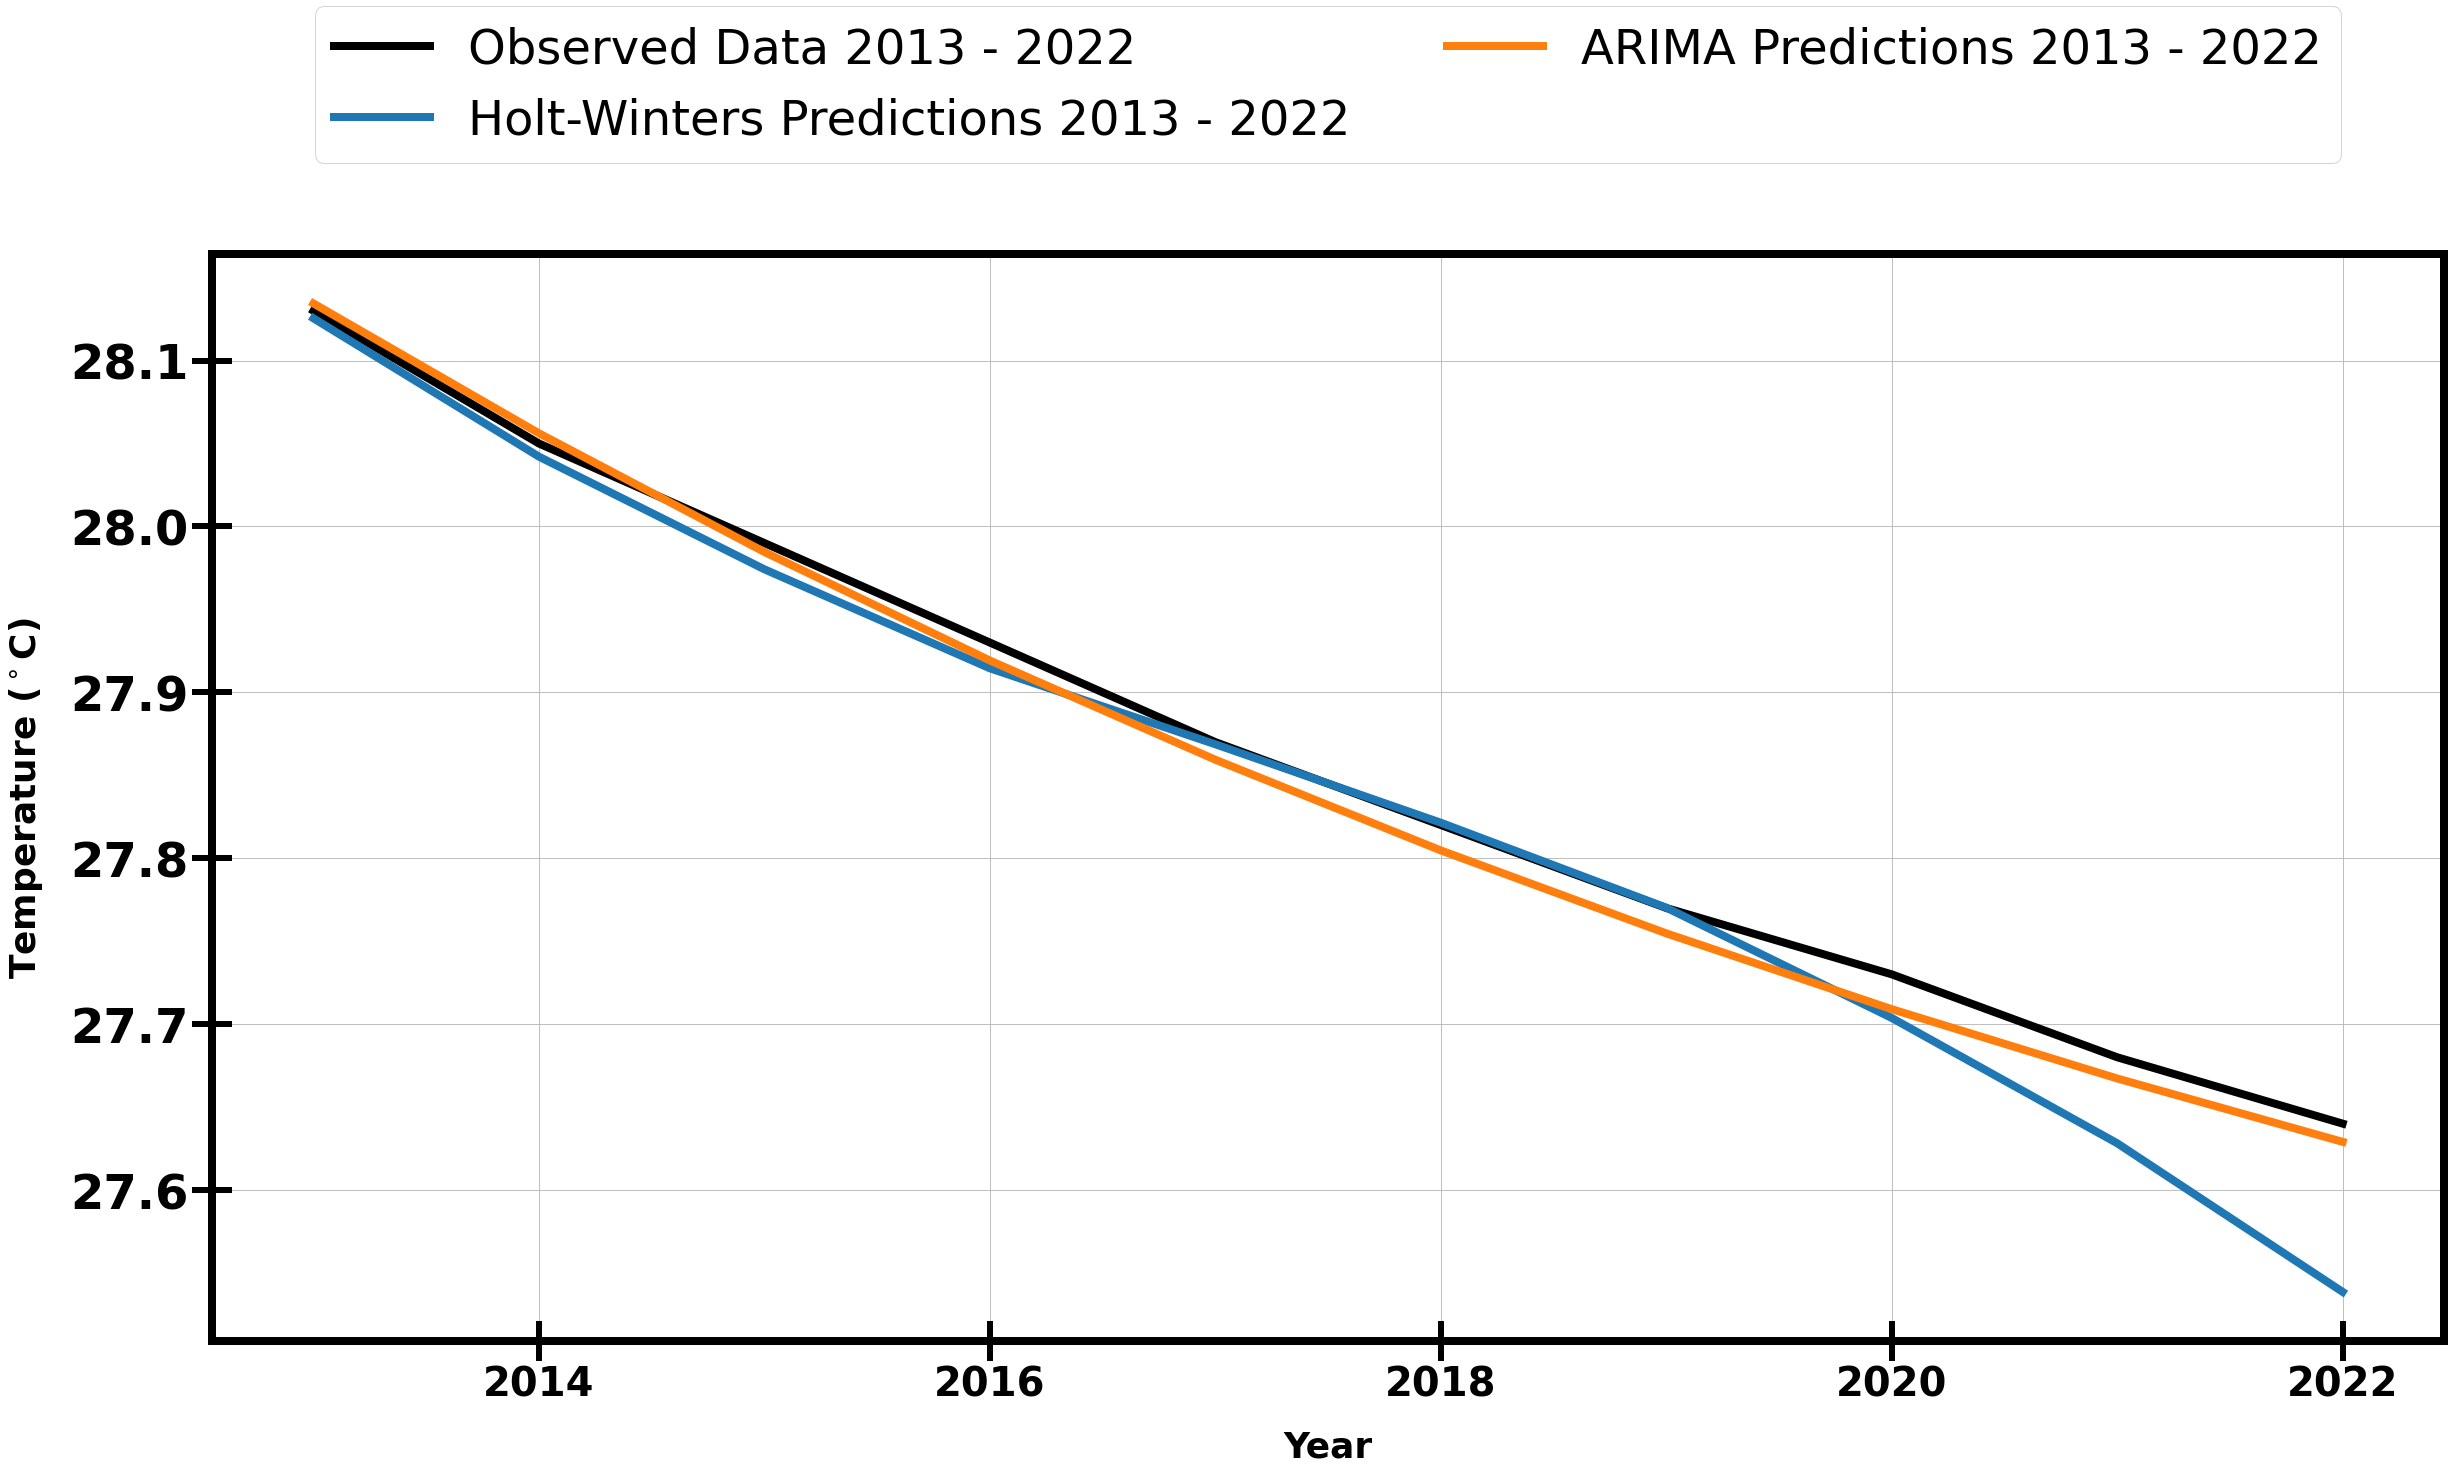

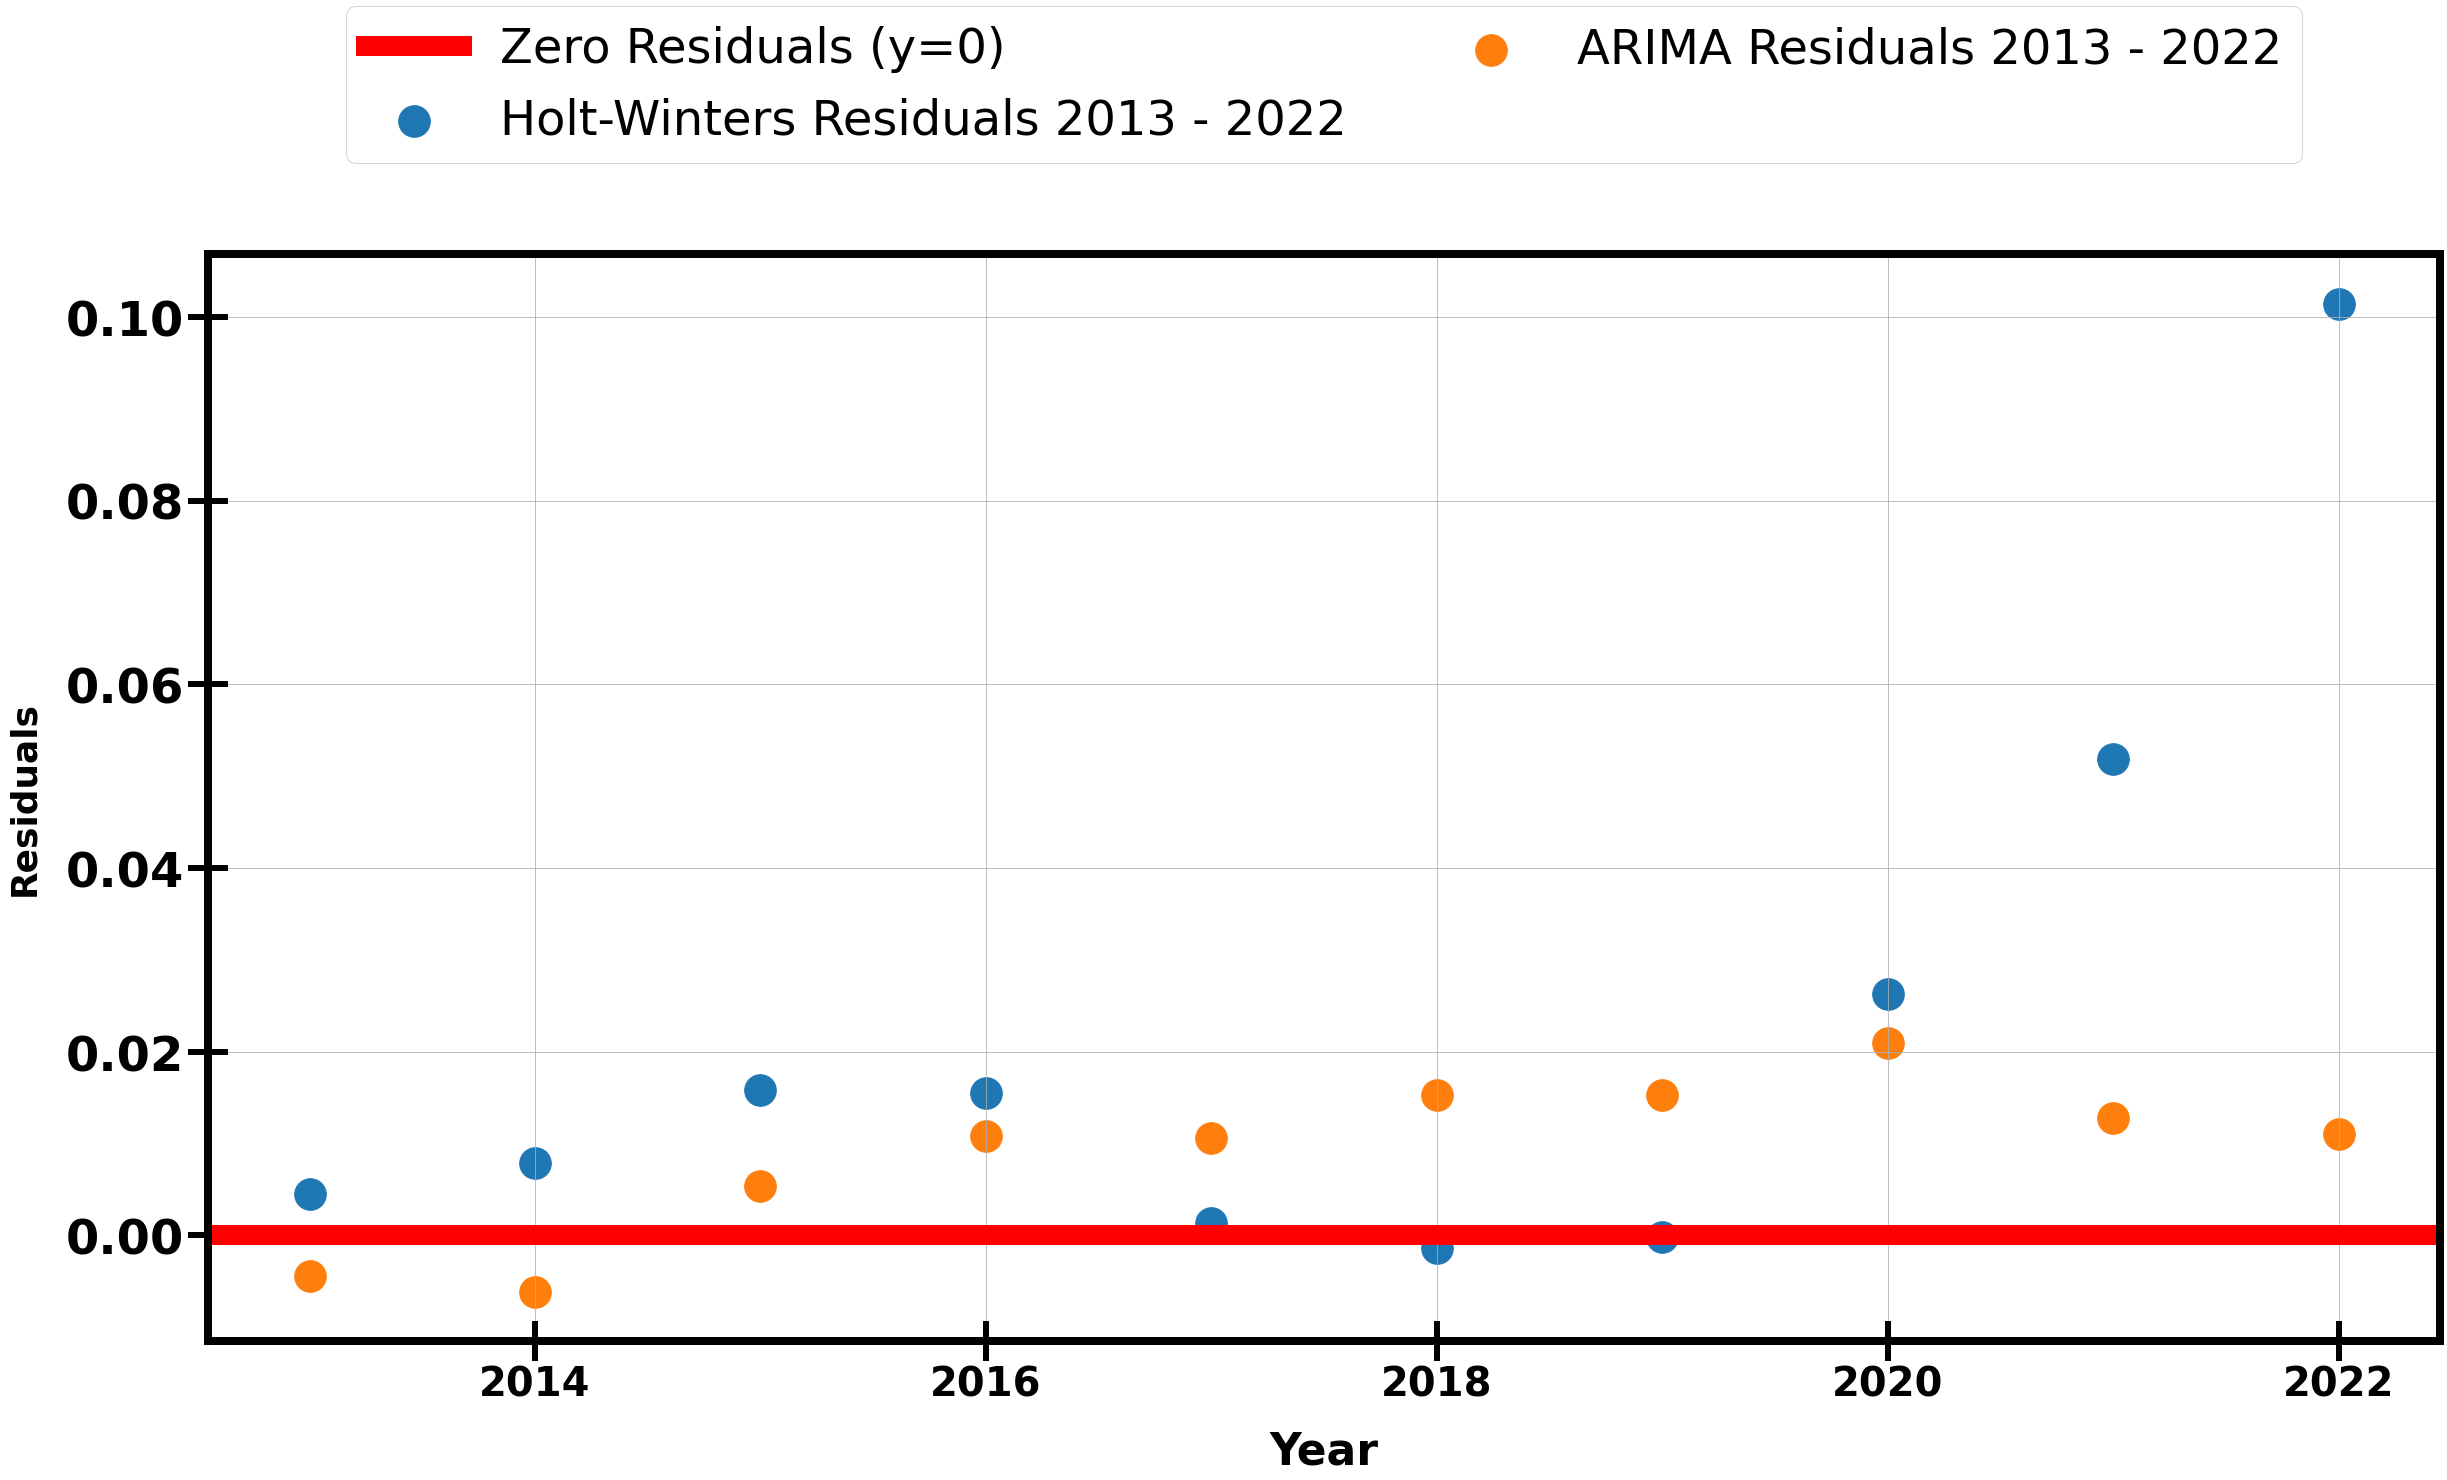

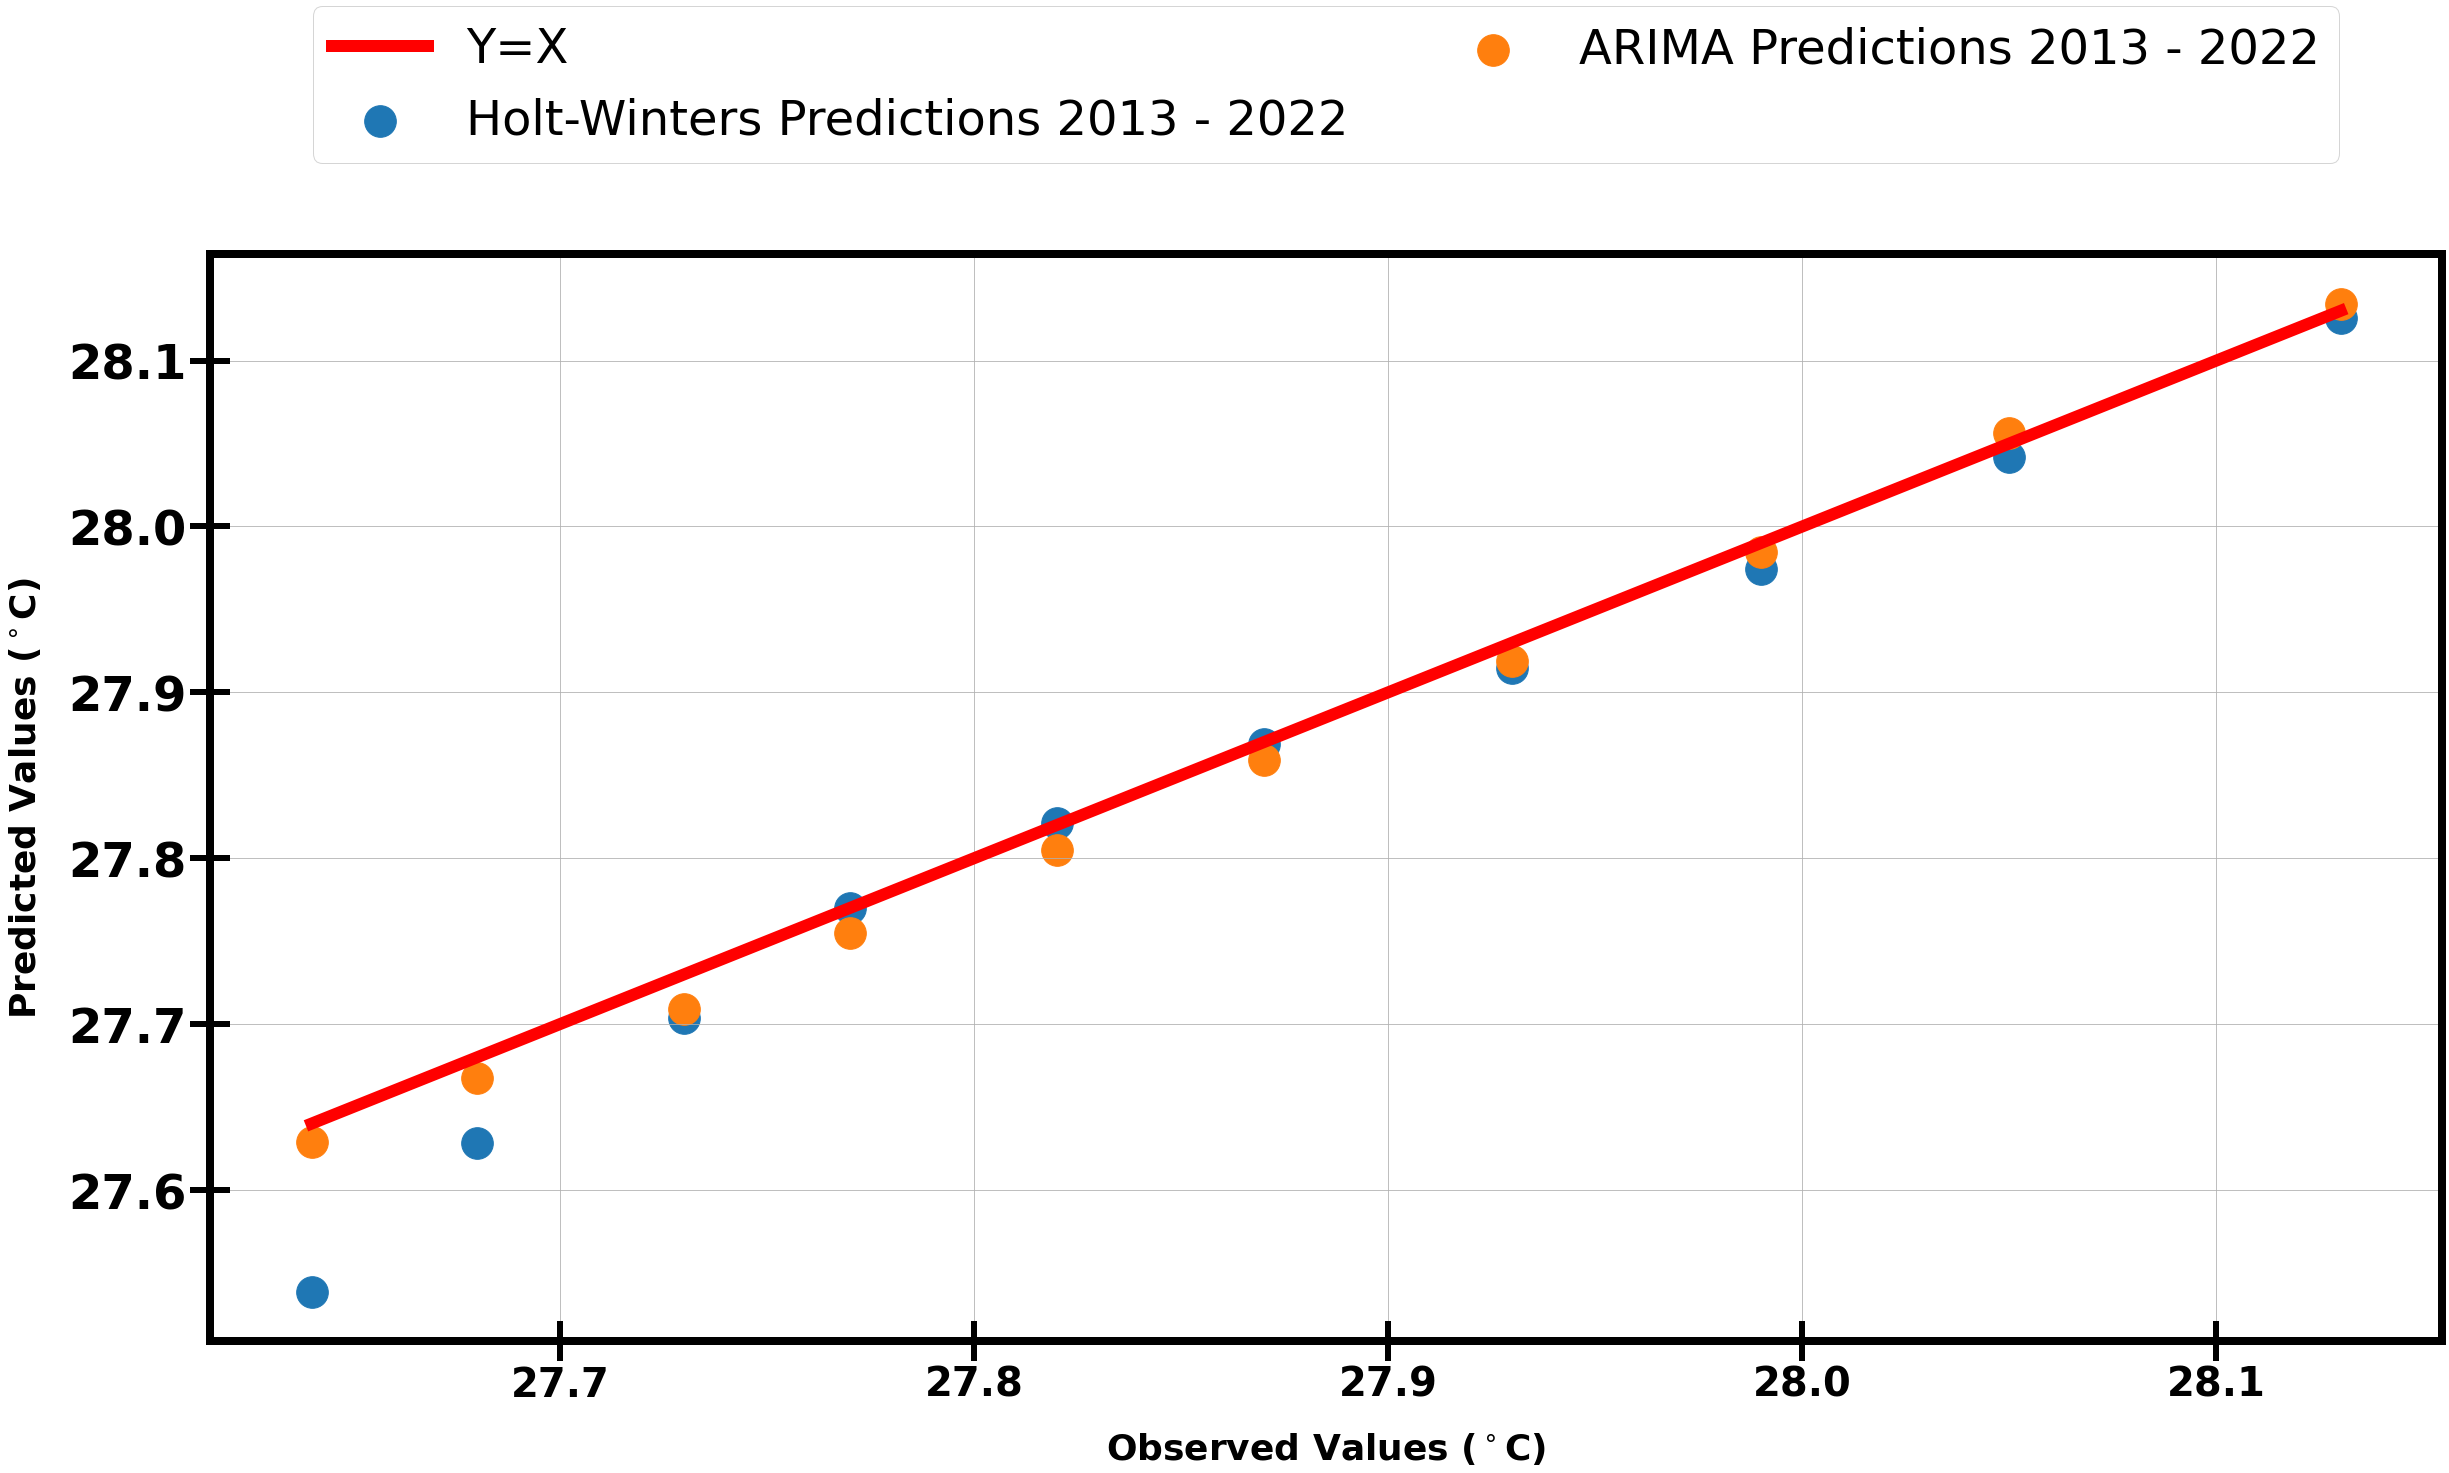

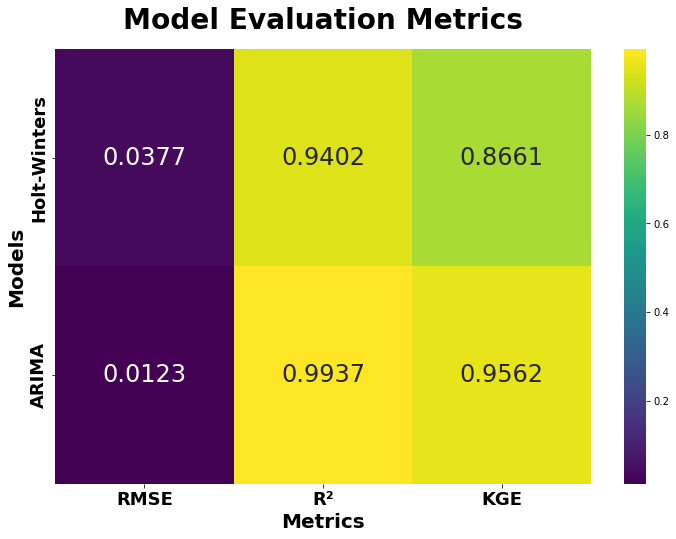

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


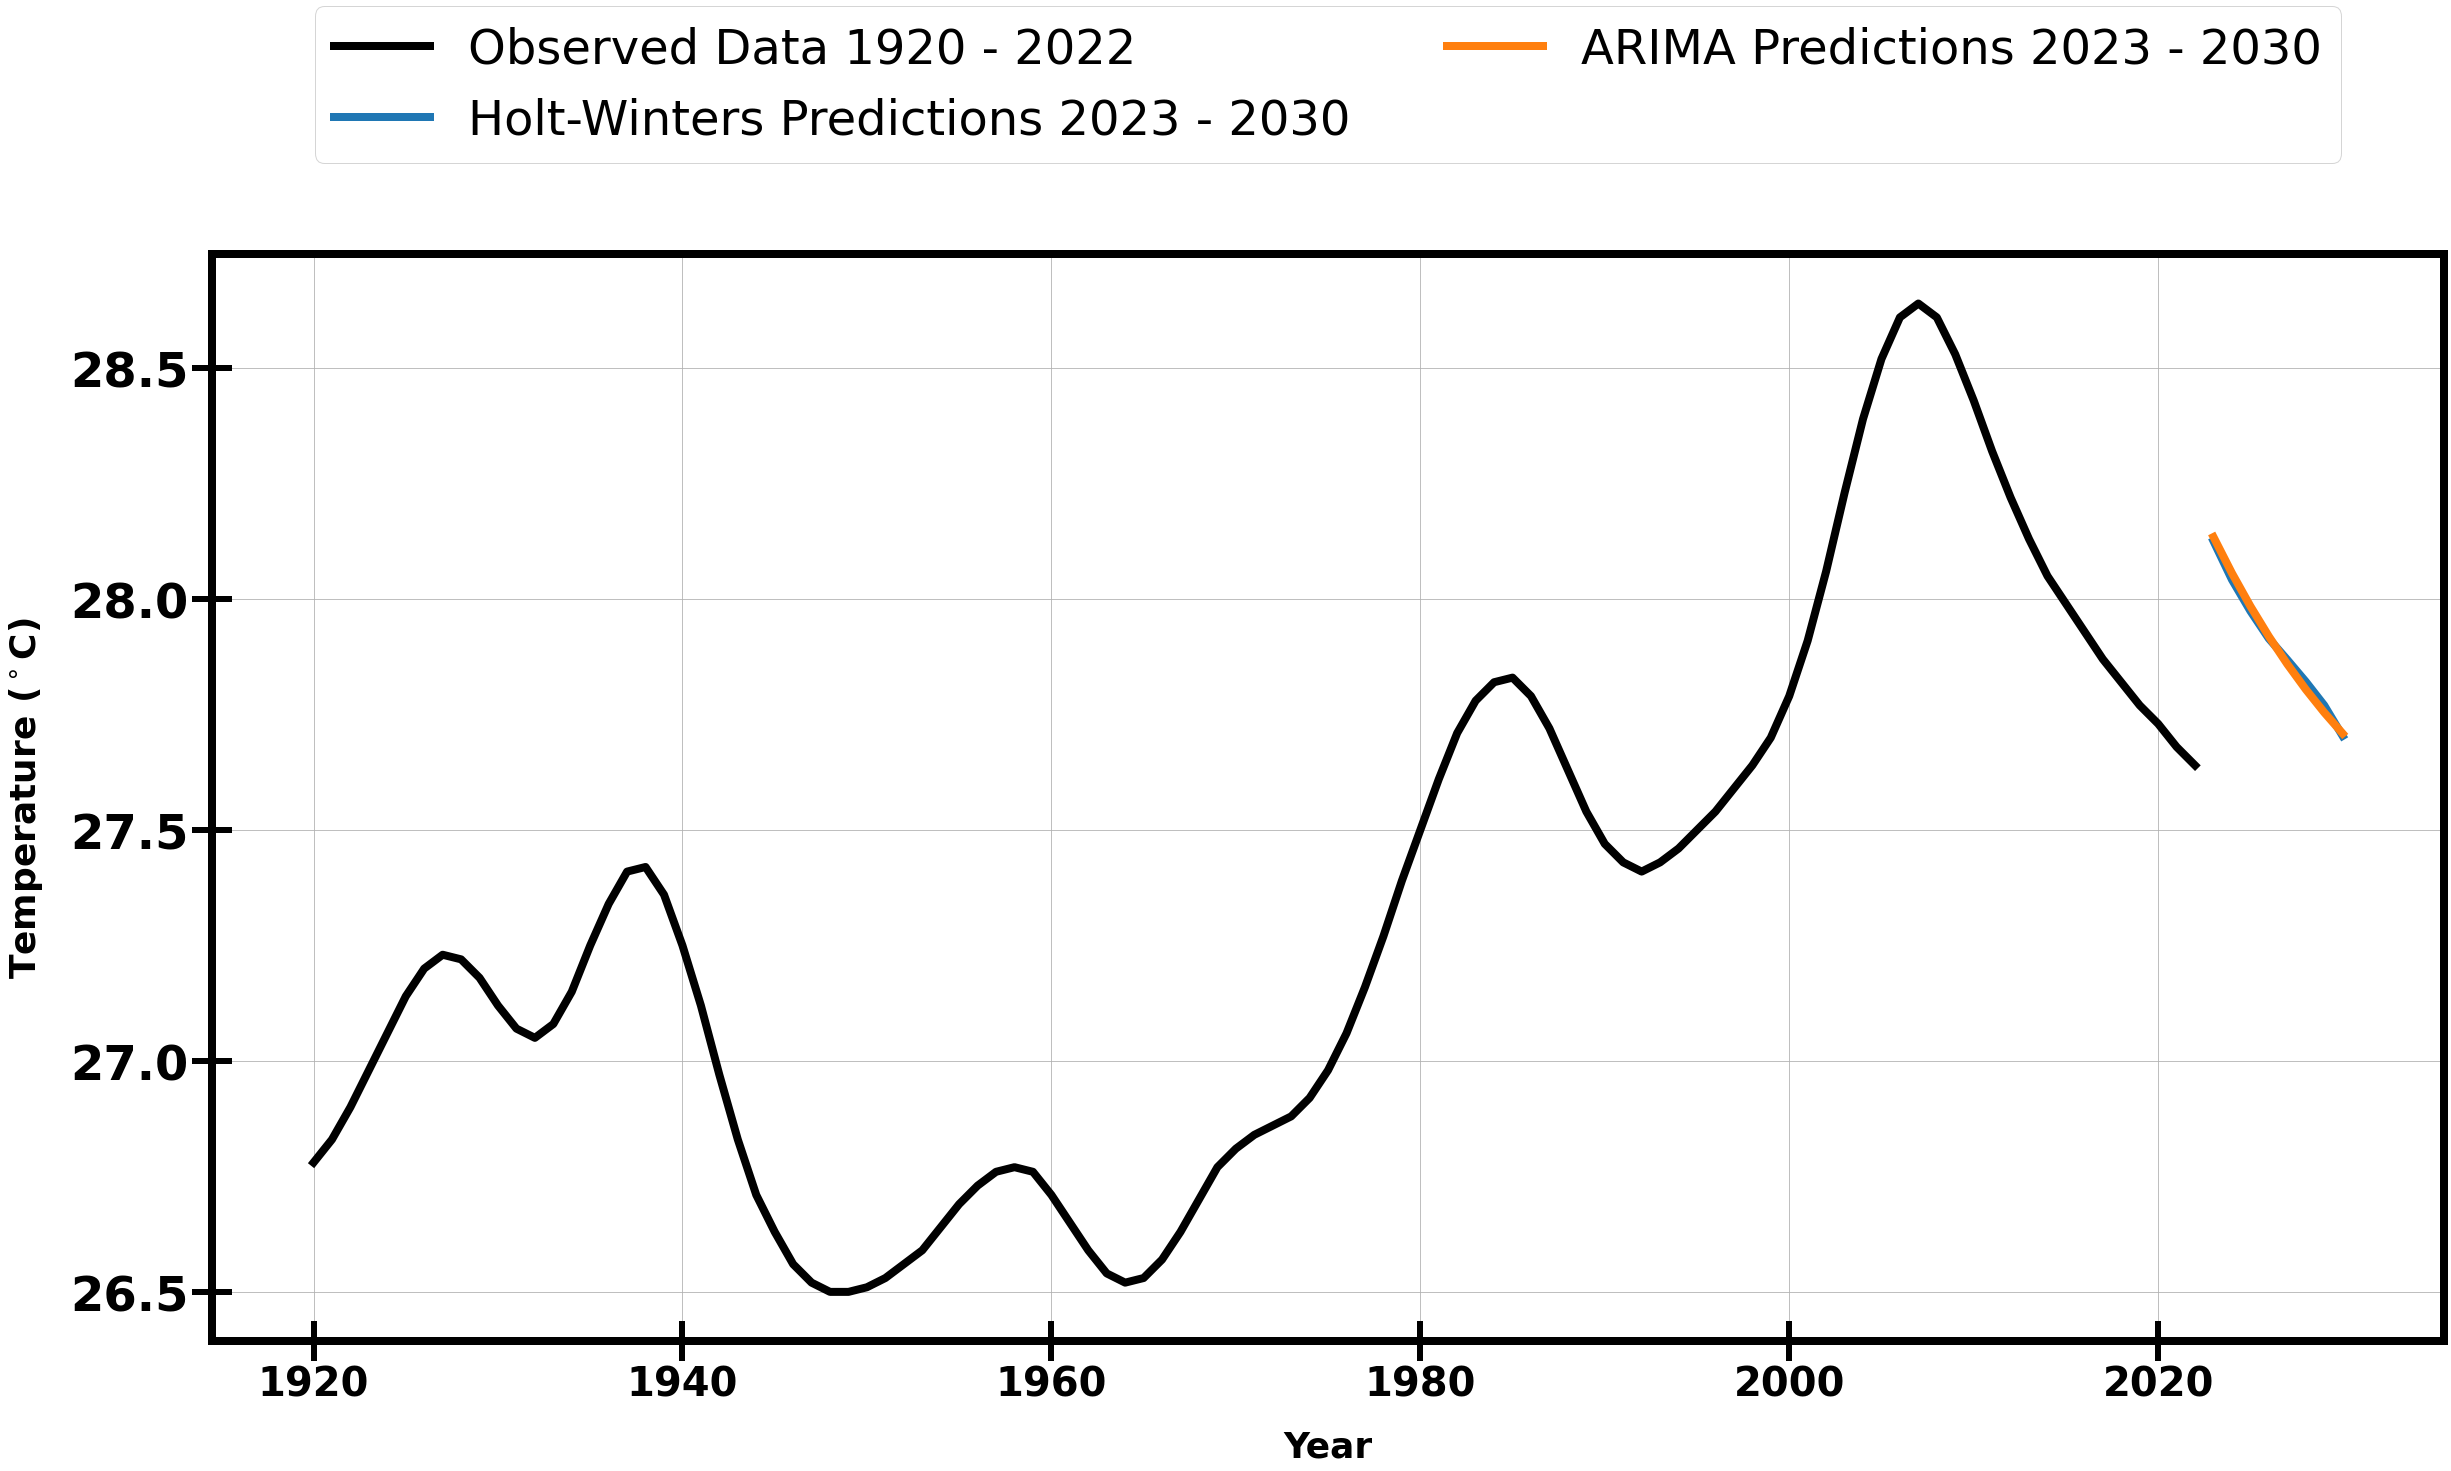

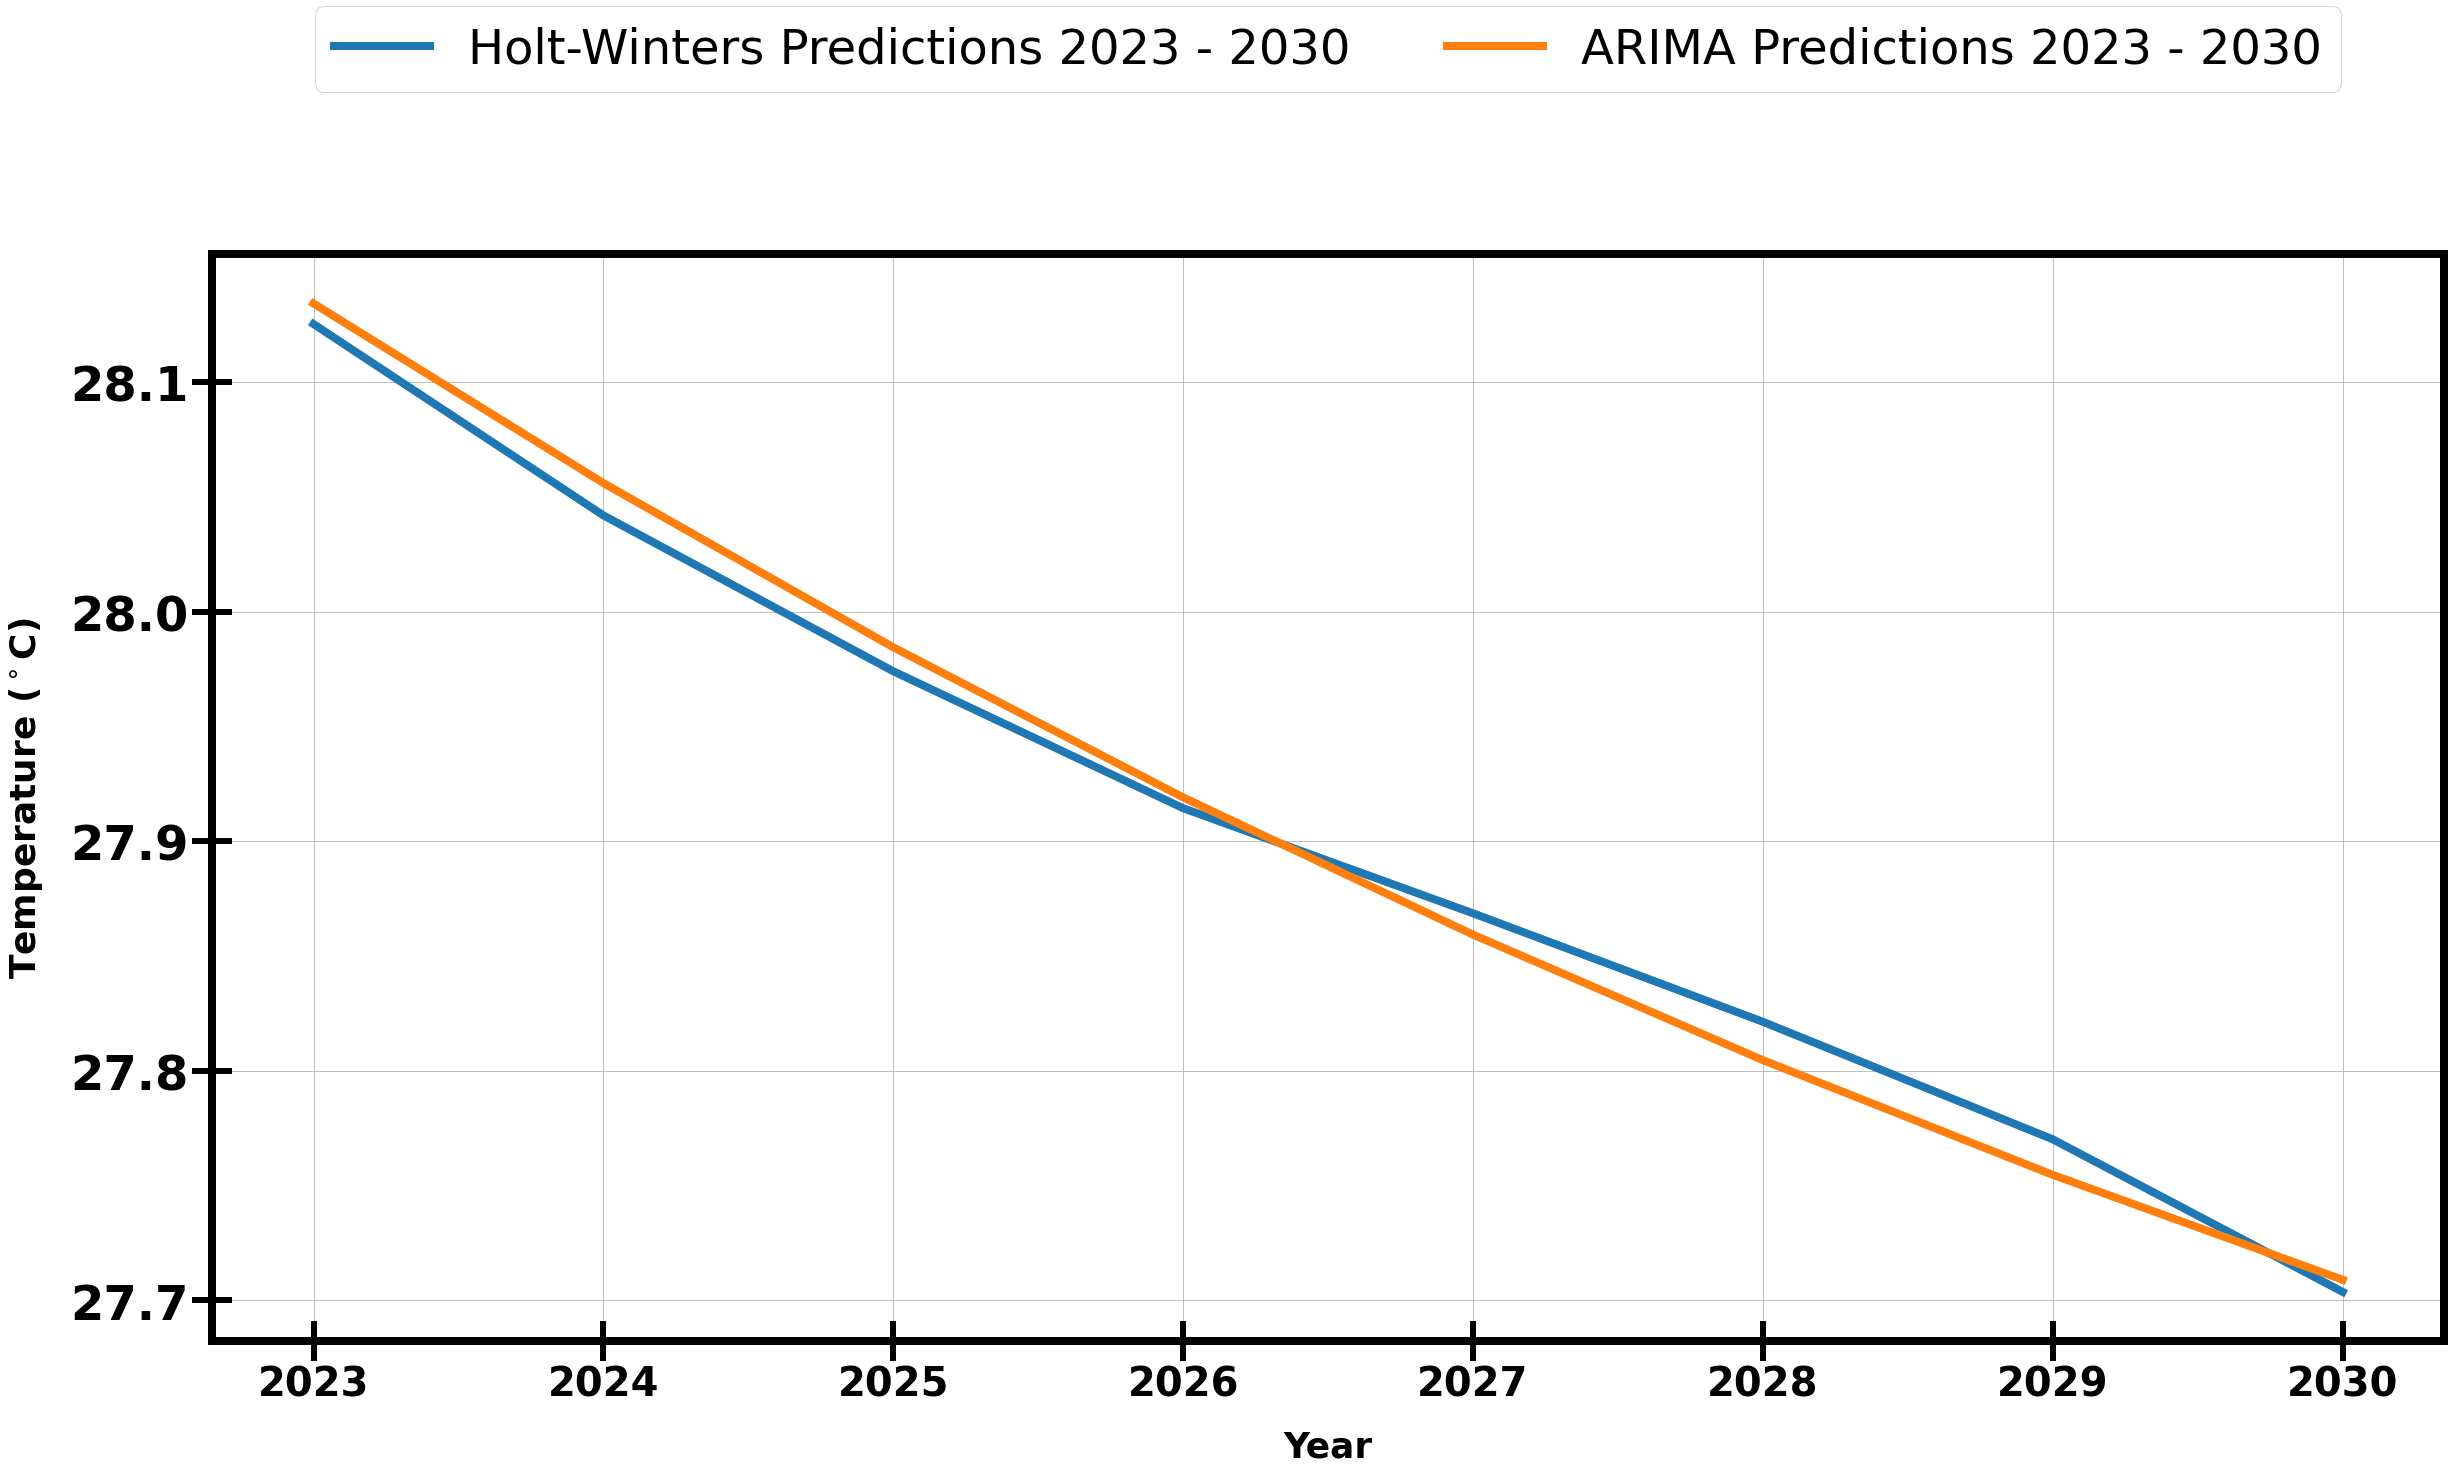

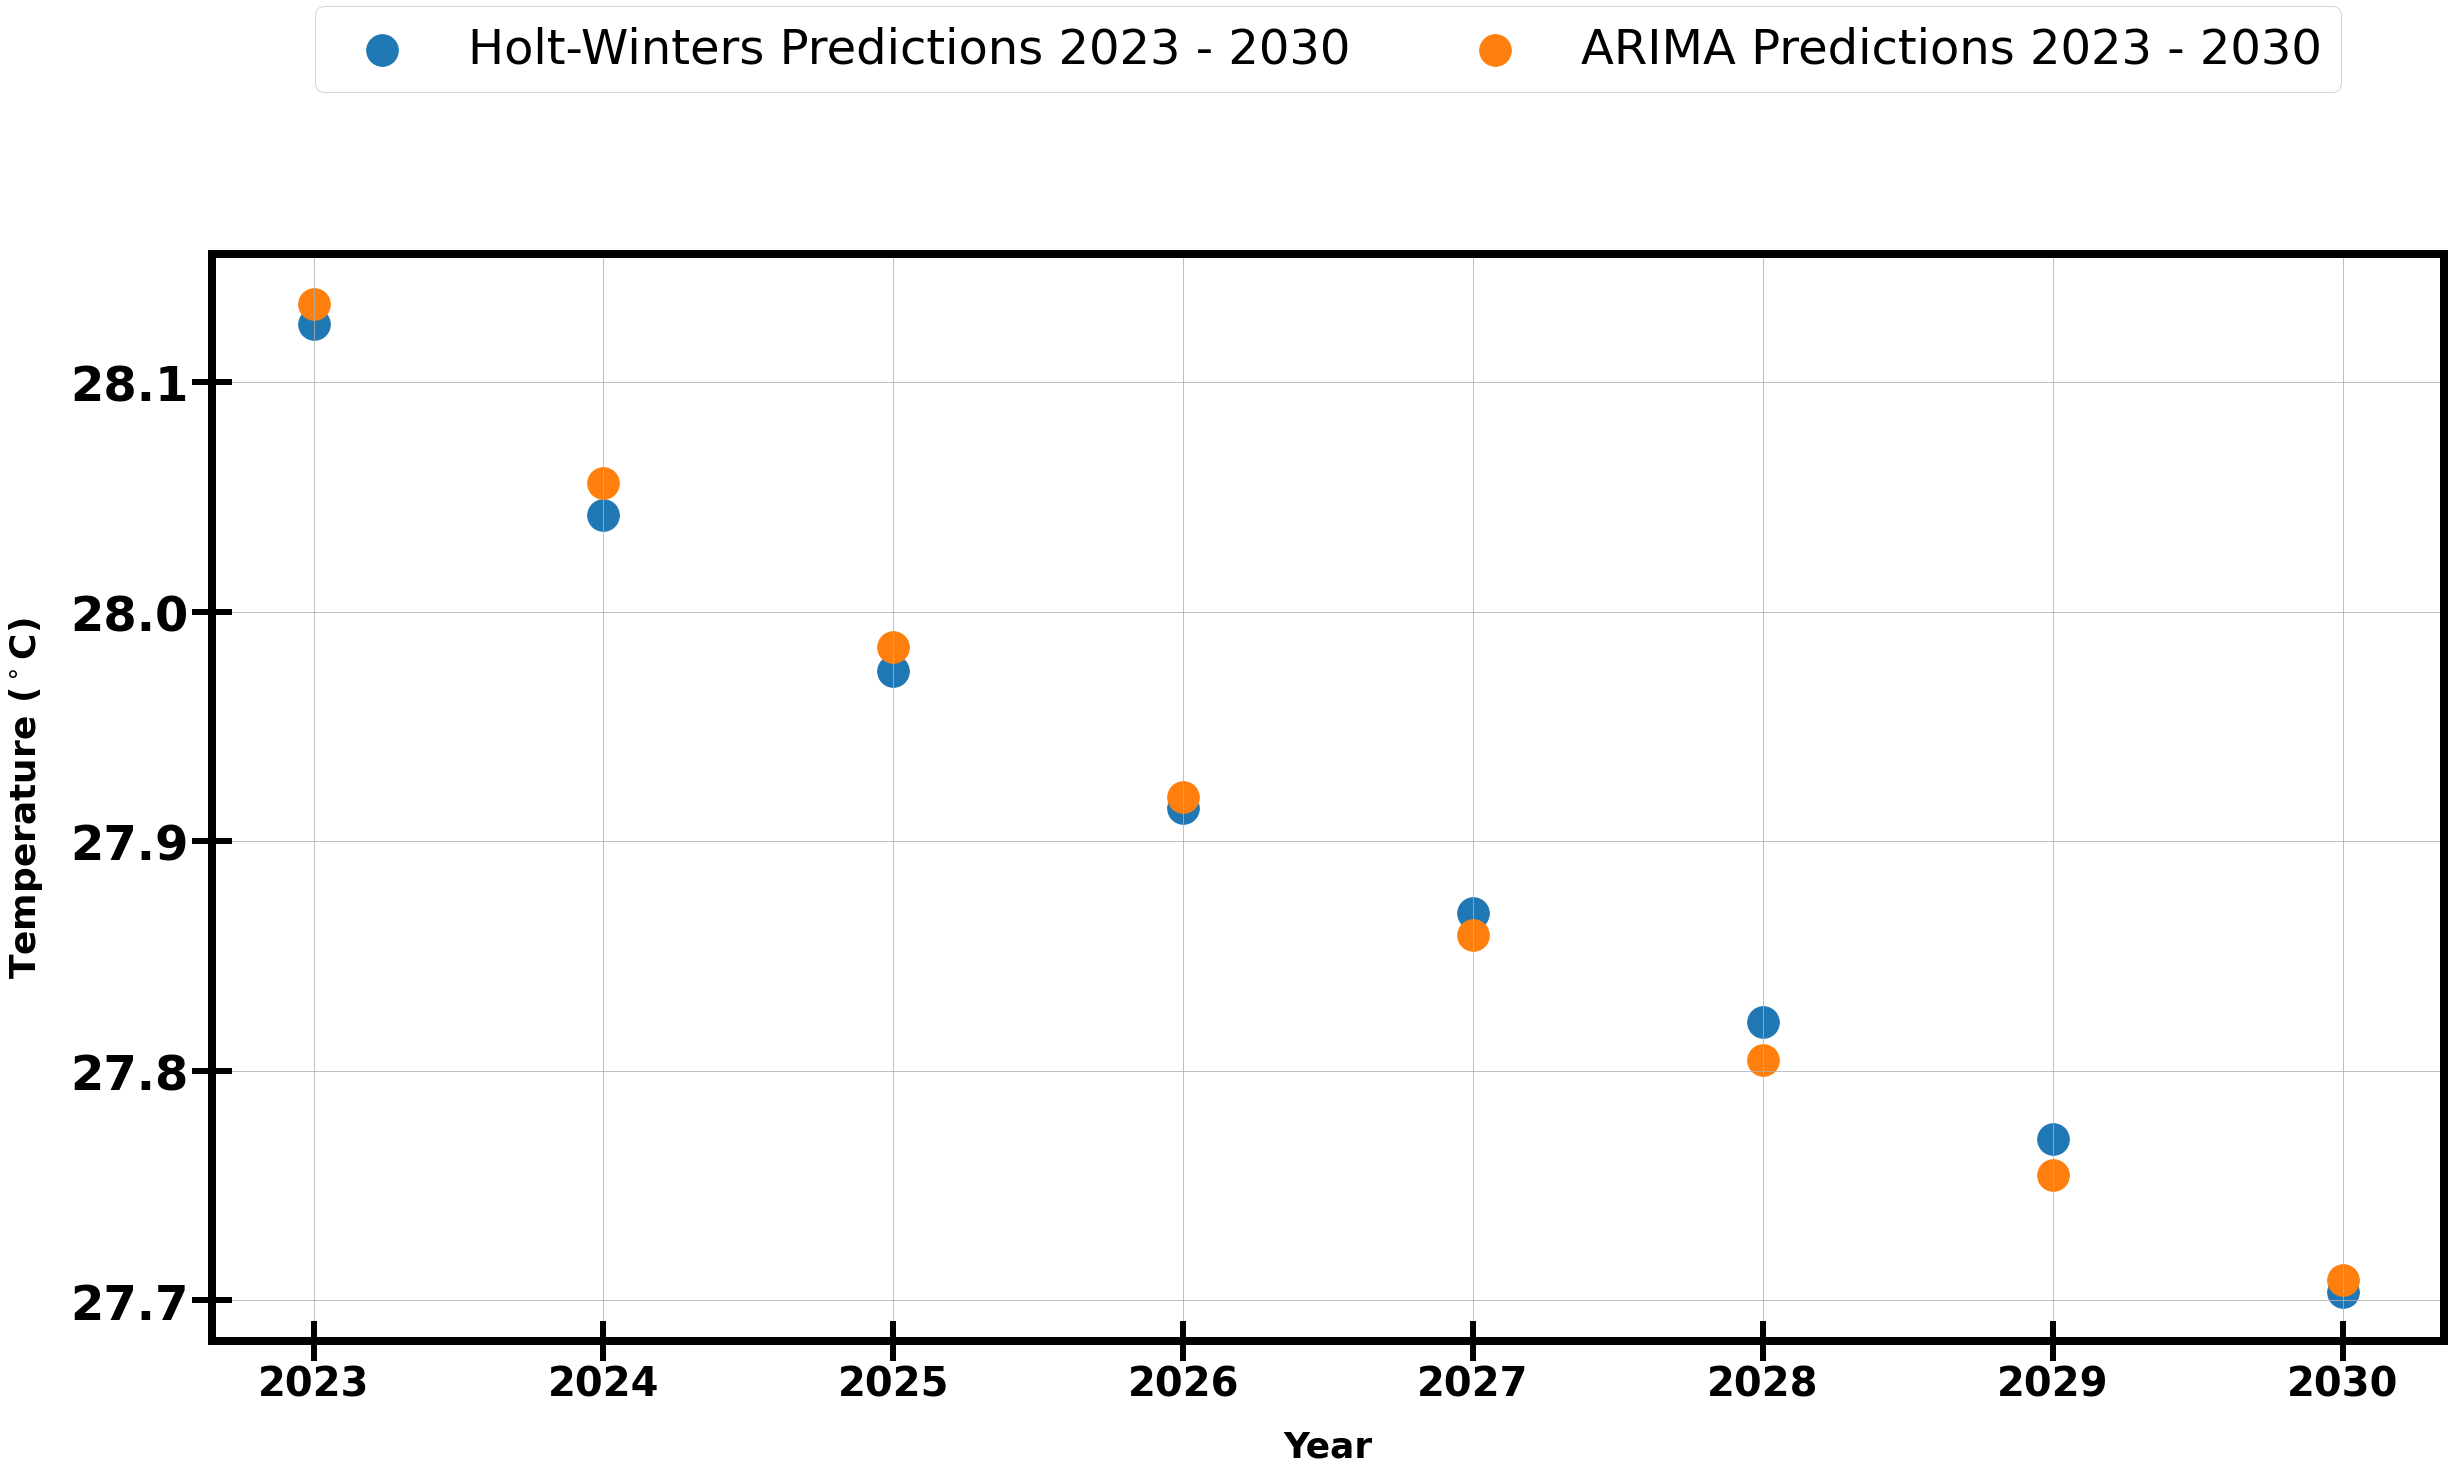

In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA  # For ARIMA
from sklearn.metrics import mean_squared_error, r2_score

# Load Data
data = pd.read_csv('data.csv')  # Ensure filename matches
data.columns = ['Year', 'Annual_Mean', 'Smooth_5yr']  # Ensure proper column names
data = data[['Year', 'Smooth_5yr']]
data = data[data["Year"] >= 1920]
data.set_index('Year', inplace=True)

# Outlier Handling (using rolling and exponential smoothing)
def outlier_removal(df, window=5, alpha=0.1):
    df['Rolling_Mean'] = df['Smooth_5yr'].rolling(window=window).mean()
    df['Exponential_Smoothing'] = df['Smooth_5yr'].ewm(span=window, adjust=False).mean()
    df['Outlier_Enhanced'] = np.where(abs(df['Smooth_5yr'] - df['Exponential_Smoothing']) > 2 * df['Smooth_5yr'].std(), df['Exponential_Smoothing'], df['Smooth_5yr'])
    return df

df = outlier_removal(data)

# Split Data into Training (1990-1999), Validation (2000-2014), and Testing (2015-2025)
train_data = df[df.index <= 2012]
valid_data = df[(df.index > 2012) & (df.index <= 2022)]
test_data = df[df.index > 2022]

# Features and Target
y_train = train_data['Outlier_Enhanced']
y_valid = valid_data['Outlier_Enhanced']
y_test = test_data['Outlier_Enhanced']

# Define Models (adding ARIMA to existing Holt-Winters)
models = {
    "Holt-Winters": ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=12),
    "ARIMA": ARIMA(y_train, order=(1, 1, 1))
}

# Function to Calculate Kling-Gupta Efficiency (KGE)
def kling_gupta_efficiency(observed, predicted):
    r = np.corrcoef(observed, predicted)[0, 1]
    beta = np.mean(predicted) / np.mean(observed)
    alpha = np.std(predicted) / np.std(observed)
    kge = 1 - np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)
    return kge

# Function for Model Training and Evaluation
def train_and_evaluate(model, model_name):
    model_fitted = model.fit()
    predictions = model_fitted.forecast(steps=len(y_valid))

    # Evaluation
    rmse = np.sqrt(mean_squared_error(y_valid, predictions))
    r2 = r2_score(y_valid, predictions)
    kge = kling_gupta_efficiency(y_valid.values, predictions)

    return rmse, r2, kge, predictions

# Evaluate All Models
results = {}
predictions_dict = {}
for model_name, model in models.items():
    rmse, r2, kge, predictions = train_and_evaluate(model, model_name)
    results[model_name] = {"RMSE": rmse, "R²": r2, "KGE": kge}
    predictions_dict[model_name] = predictions

# Display Results
for model_name, result in results.items():
    print(f"{model_name} - RMSE: {result['RMSE']:.4f}, R²: {result['R²']:.4f}, KGE: {result['KGE']:.4f}")

# Define the directory to save the plots and results
output_dir = 'output_plots'
os.makedirs(output_dir, exist_ok=True)  # Create directory if it doesn't exist

# Save evaluation results to Excel
results_df = pd.DataFrame(results).T
results_df.to_excel(os.path.join(output_dir, 'evaluation_results.xlsx'), index_label='Model')

# Time Series Data from 1920 to 2022
plt.figure(figsize=(40, 20))  # Increased size
plt.plot(df.index[df.index <= 2022], df['Outlier_Enhanced'][df.index <= 2022], label='Temperature Data 1920 - 2022', color='blue', linewidth=8)  # Increased linewidth
plt.xlabel('Year', fontsize=36, fontweight='bold', labelpad=25)  # Increased font size
plt.ylabel('Temperature ($^\circ$C)', fontsize=36, fontweight='bold', labelpad=25)  # Increased font size
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=1, fontsize=48)  # Increased font size

# Increase the thickness of the plot's borders (spines)
for spine in plt.gca().spines.values():
    spine.set_linewidth(8)  # Increased spine thickness

plt.tick_params(axis='both', which='major', labelsize=40, width=6, length=40, direction='inout')  # Increased tick size
plt.xticks(fontsize=40, fontweight='bold')  # Increased font size
plt.yticks(rotation=360, fontsize=48, fontweight='bold')  # Increased font size
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'timeseries_1920_2022.png'), dpi=300, bbox_inches='tight')
plt.show()  # Display the plot



# Plotting Training vs Observed vs Prediction for All Models
plt.figure(figsize=(40, 20))  # Increased size
plt.plot(train_data.index, y_train, label='Training Data 1920 - 2012', color='blue', linewidth=8)  # Increased linewidth
plt.plot(valid_data.index, y_valid, label='Observed Data 2013 - 2022', color='black', linewidth=8)  # Increased linewidth
for model_name, predictions in predictions_dict.items():
    plt.plot(valid_data.index, predictions, label=f'{model_name} Predictions 2013 - 2022', linewidth=8)  # Increased linewidth
plt.xlabel('Year', fontsize=36, fontweight='bold', labelpad=25)  # Increased font size
plt.ylabel('Temperature ($^\circ$C)', fontsize=36, fontweight='bold', labelpad=25)  # Increased font size
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fontsize=48)  # Increased font size

# Increase the thickness of the plot's borders (spines)
for spine in plt.gca().spines.values():
    spine.set_linewidth(8)  # Increased spine thickness

plt.tick_params(axis='both', which='major', labelsize=40, width=6, length=40, direction='inout')  # Increased tick size
plt.xticks(fontsize=40, fontweight='bold')  # Increased font size
plt.yticks(rotation=360, fontsize=48, fontweight='bold')  # Increased font size
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'training_vs_observed_vs_prediction.png'), dpi=300, bbox_inches='tight')
plt.show()  # Display the plot

# Plotting Actual vs Predicted for All Models
plt.figure(figsize=(40, 20))  # Increased size
plt.plot(valid_data.index, y_valid, label='Observed Data 2013 - 2022', color='black', linewidth=8)  # Increased linewidth
for model_name, predictions in predictions_dict.items():
    plt.plot(valid_data.index, predictions, label=f'{model_name} Predictions 2013 - 2022', linewidth=8)  # Increased linewidth
plt.xlabel('Year', fontsize=36, fontweight='bold', labelpad=25)  # Increased font size
plt.ylabel('Temperature ($^\circ$C)', fontsize=36, fontweight='bold', labelpad=25)  # Increased font size
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fontsize=48)  # Increased font size

# Increase the thickness of the plot's borders (spines)
for spine in plt.gca().spines.values():
    spine.set_linewidth(8)  # Increased spine thickness

plt.tick_params(axis='both', which='major', labelsize=40, width=6, length=40, direction='inout')  # Increased tick size
plt.xticks(fontsize=40, fontweight='bold')  # Increased font size
plt.yticks(rotation=360, fontsize=48, fontweight='bold')  # Increased font size
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'observed_vs_predictions.png'), dpi=300, bbox_inches='tight')
plt.show()  # Display the plot

# Plot Residuals (Actual - Predicted)
plt.figure(figsize=(40, 20))  # Increased size
for model_name, predictions in predictions_dict.items():
    residuals = y_valid.values - predictions  # Ensure the same length for residuals
    plt.scatter(valid_data.index, residuals, label=f'{model_name} Residuals 2013 - 2022', alpha=1, s=1000)  # Increased scatter size
plt.axhline(y=0, color='r', linestyle='-', label='Zero Residuals (y=0)', linewidth=20)  # Increased linewidth
plt.xlabel('Year', fontsize=44, fontweight='bold', labelpad=25)  # Increased font size
plt.ylabel('Residuals', fontsize=36, fontweight='bold', labelpad=25)  # Increased font size
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fontsize=48)  # Increased font size

# Increase the thickness of the plot's borders (spines)
for spine in plt.gca().spines.values():
    spine.set_linewidth(8)  # Increased spine thickness

plt.tick_params(axis='both', which='major', labelsize=40, width=6, length=40, direction='inout')  # Increased tick size
plt.xticks(fontsize=40, fontweight='bold')  # Increased font size
plt.yticks(rotation=360, fontsize=48, fontweight='bold')  # Increased font size
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'residuals_vs_observed.png'), dpi=300, bbox_inches='tight')
plt.show()  # Display the plot

# Scatter plot of predictions against observed values
plt.figure(figsize=(40, 20))  # Increased size
for model_name, predictions in predictions_dict.items():
    plt.scatter(y_valid, predictions, label=f'{model_name} Predictions 2013 - 2022', alpha=1, s=1000)  # Increased scatter size
plt.plot([min(y_valid), max(y_valid)], [min(y_valid), max(y_valid)], color='red', linestyle='-', label='Y=X', linewidth=12)  # Increased linewidth
plt.xlabel('Observed Values ($^\circ$C)', fontsize=36, fontweight='bold', labelpad=25)  # Increased font size
plt.ylabel('Predicted Values ($^\circ$C)', fontsize=36, fontweight='bold', labelpad=25)  # Increased font size
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fontsize=48)  # Increased font size

# Increase the thickness of the plot's borders (spines)
for spine in plt.gca().spines.values():
    spine.set_linewidth(8)  # Increased spine thickness

plt.tick_params(axis='both', which='major', labelsize=40, width=6, length=40, direction='inout')  # Increased tick size
plt.xticks(fontsize=40, fontweight='bold')  # Increased font size
plt.yticks(rotation=360, fontsize=48, fontweight='bold')  # Increased font size
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'scatter_predictions_vs_observed.png'), dpi=300, bbox_inches='tight')
plt.show()  # Display the plot

# Heatmap of Evaluation Metrics
metrics = pd.DataFrame(results).T
plt.figure(figsize=(12, 8))  # Kept original size
sns.heatmap(metrics[['RMSE', 'R²', 'KGE']], annot=True, cmap='viridis', fmt='.4f', cbar=True, 
            annot_kws={"size": 24},  # Kept original font size
            xticklabels=['RMSE', 'R²', 'KGE'], yticklabels=metrics.index)
plt.title('Model Evaluation Metrics', fontsize=28, fontweight='bold', pad=20)  # Kept original font size
plt.xlabel('Metrics', fontsize=20, fontweight='bold')  # Kept original font size
plt.ylabel('Models', fontsize=20, fontweight='bold')  # Kept original font size
plt.xticks(fontsize=18, fontweight='bold')  # Kept original font size
plt.yticks(fontsize=18, fontweight='bold')  # Kept original font size
plt.savefig(os.path.join(output_dir, 'evaluation_metrics_heatmap.png'), dpi=300, bbox_inches='tight')
plt.show()



# Predictions for 2023 to 2030
future_years = np.arange(2023, 2031)  # Years from 2023 to 2030 (inclusive of 2030)
future_predictions = {}
for model_name, model in models.items():
    model_fitted = model.fit()
    future_predictions[model_name] = model_fitted.forecast(steps=len(future_years))

# Save future predictions to Excel
future_predictions_df = pd.DataFrame(future_predictions, index=future_years)
future_predictions_df.index.name = 'Year'
future_predictions_df.to_excel(os.path.join(output_dir, 'future_predictions_2023_2030.xlsx'))

# New Plot: Predictions from 2023 to 2030 with Observed Data up to 2022
plt.figure(figsize=(40, 20))  # Increased size
plt.plot(df.index[df.index <= 2022], df['Outlier_Enhanced'][df.index <= 2022], label='Observed Data 1920 - 2022', color='black', linewidth=8)  # Increased linewidth
for model_name, predictions in future_predictions.items():
    plt.plot(future_years, predictions, label=f'{model_name} Predictions 2023 - 2030', linewidth=8)  # Increased linewidth
plt.xlabel('Year', fontsize=36, fontweight='bold', labelpad=25)  # Increased font size
plt.ylabel('Temperature ($^\circ$C)', fontsize=36, fontweight='bold', labelpad=25)  # Increased font size
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fontsize=48)  # Increased font size

# Increase the thickness of the plot's borders (spines)
for spine in plt.gca().spines.values():
    spine.set_linewidth(8)  # Increased spine thickness

plt.tick_params(axis='both', which='major', labelsize=40, width=6, length=40, direction='inout')  # Increased tick size
plt.xticks(fontsize=40, fontweight='bold')  # Increased font size
plt.yticks(rotation=360, fontsize=48, fontweight='bold')  # Increased font size
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'predictions_2023_2030.png'), dpi=300, bbox_inches='tight')
plt.show()  # Display the plot

# Only Predictions from 2023 to 2030 (No Observed Data)
plt.figure(figsize=(40, 20))  # Increased size
for model_name, predictions in future_predictions.items():
    plt.plot(future_years, predictions, label=f'{model_name} Predictions 2023 - 2030', linewidth=8)  # Increased linewidth
plt.xlabel('Year', fontsize=36, fontweight='bold', labelpad=25)  # Increased font size
plt.ylabel('Temperature ($^\circ$C)', fontsize=36, fontweight='bold', labelpad=25)  # Increased font size
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fontsize=48)  # Increased font size

# Increase the thickness of the plot's borders (spines)
for spine in plt.gca().spines.values():
    spine.set_linewidth(8)  # Increased spine thickness

plt.tick_params(axis='both', which='major', labelsize=40, width=6, length=40, direction='inout')  # Increased tick size
plt.xticks(fontsize=40, fontweight='bold')  # Increased font size
plt.yticks(rotation=360, fontsize=48, fontweight='bold')  # Increased font size
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'predictions_only_2023_2030.png'), dpi=300, bbox_inches='tight')
plt.show()  # Display the plot

# Scatter Plot of Predictions 2023 to 2030
plt.figure(figsize=(40, 20))  # Increased size
for model_name, predictions in future_predictions.items():
    plt.scatter(future_years, predictions, label=f'{model_name} Predictions 2023 - 2030', alpha=1, s=1000)  # Increased scatter size
plt.xlabel('Year', fontsize=36, fontweight='bold', labelpad=25)  # Increased font size
plt.ylabel('Temperature ($^\circ$C)', fontsize=36, fontweight='bold', labelpad=25)  # Increased font size
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2, fontsize=48)  # Increased font size

# Increase the thickness of the plot's borders (spines)
for spine in plt.gca().spines.values():
    spine.set_linewidth(8)  # Increased spine thickness

plt.tick_params(axis='both', which='major', labelsize=40, width=6, length=40, direction='inout')  # Increased tick size
plt.xticks(fontsize=40, fontweight='bold')  # Increased font size
plt.yticks(rotation=360, fontsize=48, fontweight='bold')  # Increased font size
plt.grid(True)
plt.savefig(os.path.join(output_dir, 'scatter_predictions_2023_2030.png'), dpi=300, bbox_inches='tight')
plt.show()  # Display the plot

